### Lo primero será descargar los datos para realizar el estudio

In [28]:
import requests
import zipfile
import io
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Estaciones y sus URLs base
stations = {
    'Beutenberg': 'https://www.bgc-jena.mpg.de/wetter/mpi_roof',
    'Saaleaue': 'https://www.bgc-jena.mpg.de/wetter/mpi_saale',
    'Versuchsbeete': 'https://www.bgc-jena.mpg.de/wetter/MPI_Soil'
}

Usaremos estos periodos para todos los datos porque es la forma mas sencilla de hacerlo, realmente cribará despues todo lo que no se pueda descargar. Las siguientes funciones incluyen la generacion de urls y su descarga, por lo que al ser la descaga de datos unicamente se dejaran los comentarios necesario para entender las funciones.

In [ ]:
# Aqui tenemos los periodos
periods = [
    '01.07.2002_to_31.12.2002', '01.01.2003_to_30.06.2003', '01.07.2003_to_31.12.2003', '24.11.2003_to_31.12.2003',
    '01.01.2004_to_30.06.2004', '01.07.2004_to_31.12.2004', '01.01.2005_to_30.06.2005', '01.07.2005_to_31.12.2005', 
    '01.01.2006_to_30.06.2006', '01.07.2006_to_31.12.2006', '01.01.2007_to_30.06.2007', '01.07.2007_to_31.12.2007',
    '01.01.2008_to_30.06.2008', '01.07.2008_to_31.12.2008', '01.01.2009_to_30.06.2009', '01.07.2009_to_31.12.2009',
    '01.01.2010_to_30.06.2010', '01.07.2010_to_31.12.2010', '01.01.2011_to_30.06.2011', '01.07.2011_to_31.12.2011',
    '01.01.2012_to_30.06.2012', '01.07.2012_to_31.12.2012', '01.01.2013_to_30.06.2013', '01.07.2013_to_31.12.2013',
    '01.01.2014_to_30.06.2014', '01.07.2014_to_31.12.2014', '01.01.2015_to_30.06.2015', '01.07.2015_to_31.12.2015',
    '01.01.2016_to_30.06.2016', '01.07.2016_to_31.12.2016', '01.01.2017_to_30.06.2017', '01.07.2017_to_31.12.2017',
    '01.01.2018_to_30.06.2018', '01.07.2018_to_31.12.2018', '01.01.2019_to_30.06.2019', '01.07.2019_to_31.12.2019',
    '01.01.2020_to_30.06.2020', '01.07.2020_to_31.12.2020', '01.01.2021_to_30.06.2021', '01.07.2021_to_31.12.2021',
    '01.01.2022_to_30.06.2022', '01.07.2022_to_31.12.2022', '01.01.2023_to_30.06.2023', '01.07.2023_to_31.12.2023',
    '01.01.2024_up_to_today'
]

# Función para generar las URLs de los archivos ZIP
def generate_urls(base_url, periods):
    urls = []
    for period in periods:
        if 'up_to_today' in period:
            urls.append(f"{base_url}.zip")
        else:
            year_part = period.split('_')[-1].split('.')[2]
            half_part = 'a' if '01.01' in period else 'b'
            urls.append(f"{base_url}_{year_part}{half_part}.zip")
    return urls

# Carpeta temporal para almacenar archivos ZIP y CSV, tampoco le haremos mucho caso a ésta
temp_dir = 'weather_data'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# Tiene sus casos de uso para ver si ha conseguido hacer la descarga o no, nos ayuda tambien a saber en que punto de la descarga estamos
def download_and_extract_zip(url, extract_to):
    try:
        response = requests.get(url)
        response.raise_for_status()
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            z.extractall(extract_to)
    except requests.exceptions.RequestException as e:
        print(f"Error al descargar el archivo: {url}\n{e}")
    except zipfile.BadZipFile:
        print(f"El archivo descargado no es un archivo ZIP válido: {url}")

# Sobre las codificaciones, no hay que hacerle mucho caso a esto, tuve bastantes problemas con respecto a las codificaciones y tuve que probar con bastantes
def read_csv_with_encoding(file_path):
    encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']
    for encoding in encodings:
        try:
            return pd.read_csv(file_path, sep='\t', encoding=encoding)
        except UnicodeDecodeError:
            continue
    raise ValueError(f"No se pudo decodificar el archivo {file_path} con las codificaciones probadas.")

# Con rspecto a los datos, he tenido que procesarlos en el momento de generar el csv. No se explicar el motivo, pero he tenido MUCHOS problemas a la hora de generar un csv decente concatenando los csvs de esta pagina
# De verdad esta parte me llevó mucho tiempo y he perdido mas tiempo del que me gustaría admitir en esta parte.
def process_station(station_name, base_url, periods):
    urls = generate_urls(base_url, periods)
    all_data = []
    for url in urls:
        print(f"Descargando y extrayendo {url}")
        download_and_extract_zip(url, temp_dir)
        
        # Buscar todos los archivos CSV en la carpeta temporal
        for file in os.listdir(temp_dir):
            if file.endswith('.csv'):
                file_path = os.path.join(temp_dir, file)
                try:
                    df = read_csv_with_encoding(file_path)
                    all_data
                    all_data.append(df)
                except (pd.errors.ParserError, ValueError) as e:
                    print(f"Error al leer el archivo CSV: {file_path}\n{e}")
                os.remove(file_path)

    
    if all_data:
        # Especificar explícitamente los nombres de las columnas sin comillas dobles
        combined_df = pd.concat(all_data, ignore_index=True)
        columns_without_quotes = combined_df.columns.str.replace('"', '')
        combined_df.columns = columns_without_quotes
        
        # Guardar el archivo CSV sin comillas y con el delimitador correcto
        combined_df.to_csv(f'{station_name}.csv', index=False, sep=',', quoting=csv.QUOTE_NONE, escapechar='\\')
        print(f'Datos combinados guardados en {station_name}.csv')

# Procesar cada estación
for station, base_url in stations.items():
    process_station(station, base_url, periods)

# Cuando termina de concatenar todos los archivos, los guarda aqui. Por eso decía que no le prestaramos demasiada atencion a esta parte, no era especialmente relevante en realidad.
os.rmdir(temp_dir)

Aqui, lo primero, leeremos el csv que hemos descargado anteriormente. Me gustaría aclarar que a pesar de hacer la descarga de las 3 estaciones, se hará unicamente el trabajo con uno de los csvs. Esto se debe a que hacerlo con 3 estaciones era demasiado complejo para la cantidad de tiempo disponible y no habiendo conseguido unos resultados que se consideren del todo satisfactorios por el estudiante para una de las estaciones y, de nuevo, por falta de tiempo, se mantiene el estudio y las predicciones para una unica estacion.

In [4]:
csv_file = 'Beuten.csv'
data = pd.read_csv(csv_file, sep=r',\s*', engine='python')

Se hace una pequeña limpieza sobre los datos y algunos caracteres que se han colado en el csv

In [5]:
data.columns = data.columns.str.replace(r'\\', '', regex=True).str.strip()

# Limpiar los datos eliminando caracteres de escape y espacios extra
data = data.applymap(lambda x: x.replace('\\', '').strip() if isinstance(x, str) else x)


C:\Users\unais\AppData\Local\Temp\ipykernel_6008\80148196.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x.replace('\\', '').strip() if isinstance(x, str) else x)


Se establece la columna de las fechas como formato datetime, ya que mas adelante nos resultará util que se encuentre en este formato por multiples motivos (entre ellos para el entrenamiento y la visualizacion)

In [6]:

date_column = 'Date Time'

# Convertir la columna de fecha y hora a datetime de manera flexible
data[date_column] = pd.to_datetime(data[date_column], format='%d.%m.%Y %H:%M:%S', errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029536 entries, 0 to 1029535
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Date Time             1029536 non-null  datetime64[ns]
 1   p (mbar)              1029536 non-null  float64       
 2   T (degC)              1029536 non-null  float64       
 3   Tpot (K)              1029536 non-null  float64       
 4   Tdew (degC)           1029536 non-null  float64       
 5   rh (%)                1029536 non-null  float64       
 6   VPmax (mbar)          1029536 non-null  float64       
 7   VPact (mbar)          1029536 non-null  float64       
 8   VPdef (mbar)          1029536 non-null  float64       
 9   sh (g/kg)             1029536 non-null  float64       
 10  H2OC (mmol/mol)       1029536 non-null  float64       
 11  rho (g/m**3)          1029536 non-null  float64       
 12  wv (m/s)              1029536 non-null  fl

Se establece esta columna como indice y le hacemos un pequeño estudio, con intención de sacar informacion de esta.
Como son demasiados datos, se le hará un muestreo de 3 en 3, es decir, se representará un dato cada media hora en vez de cada 10 minutos, puesto que la diferencia entre los datos no debería ser muy grande y ahorra mucha capacidad de computo a futuro, ademas de que se hace mas facil su representación.

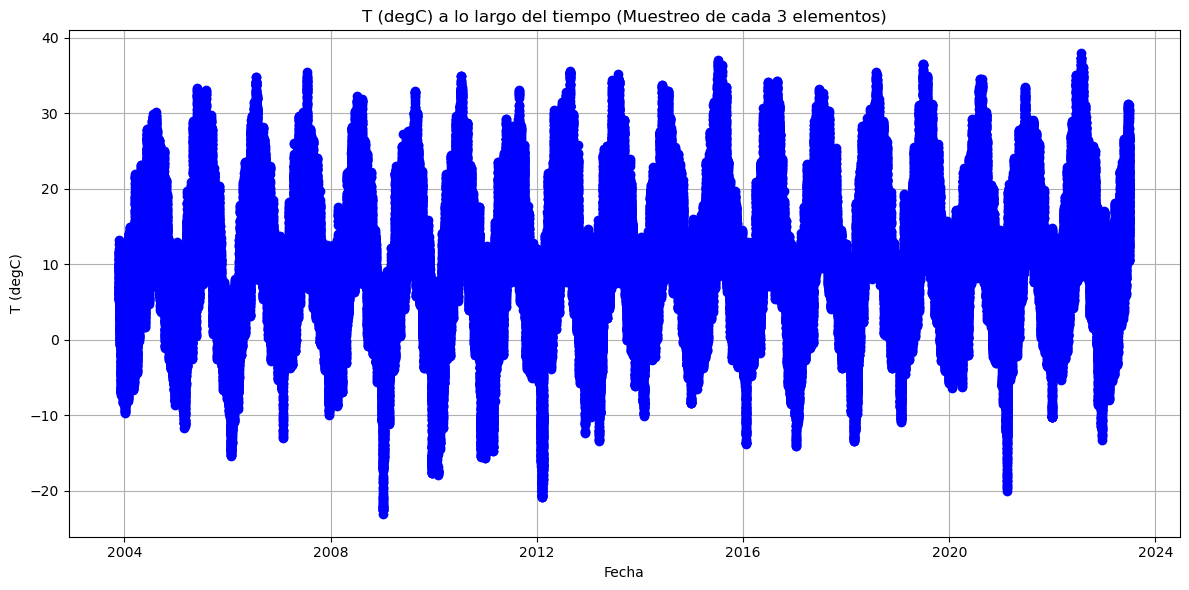

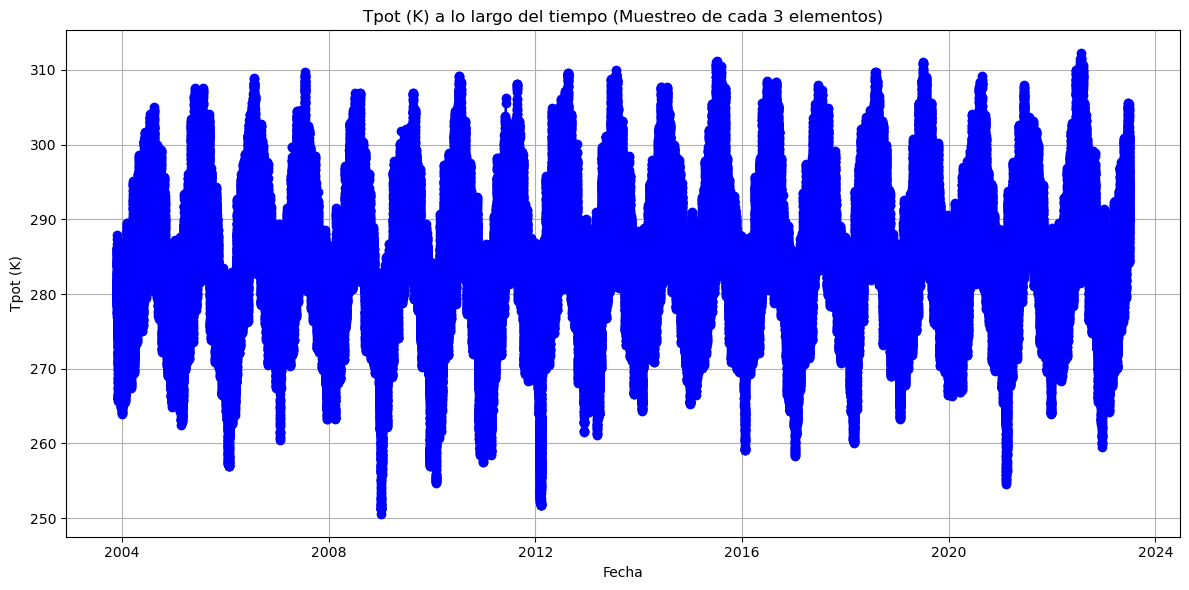

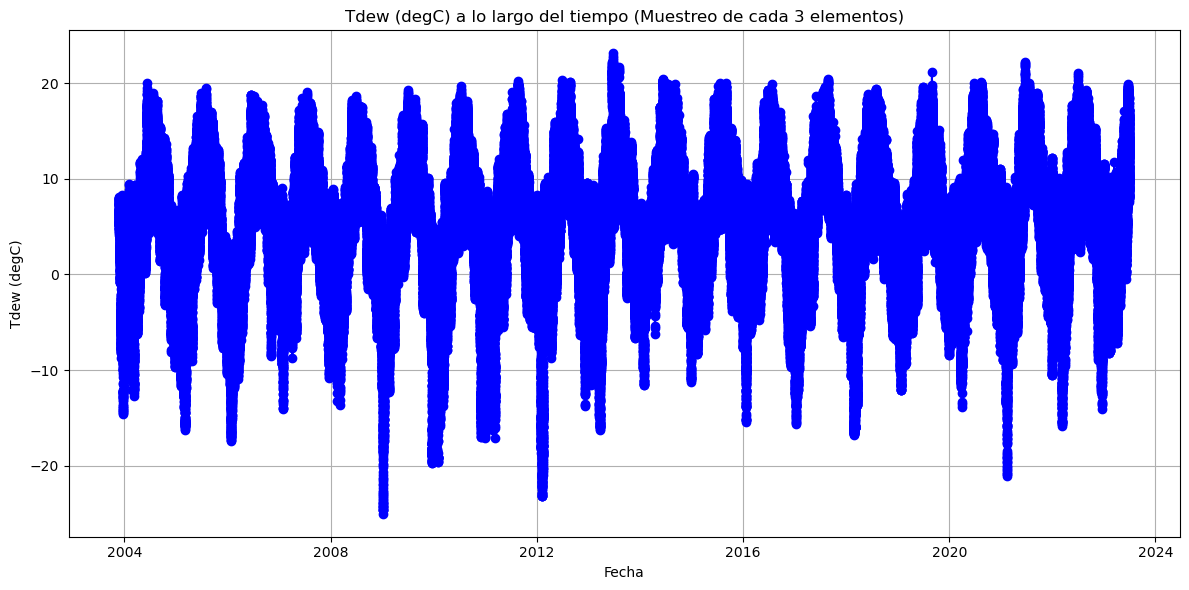

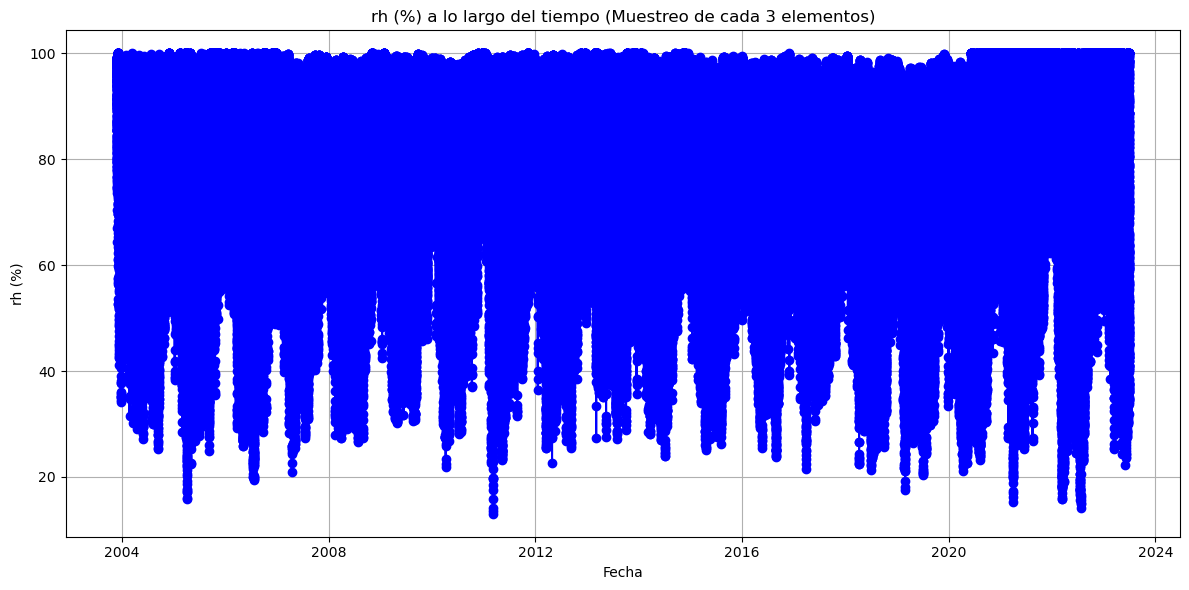

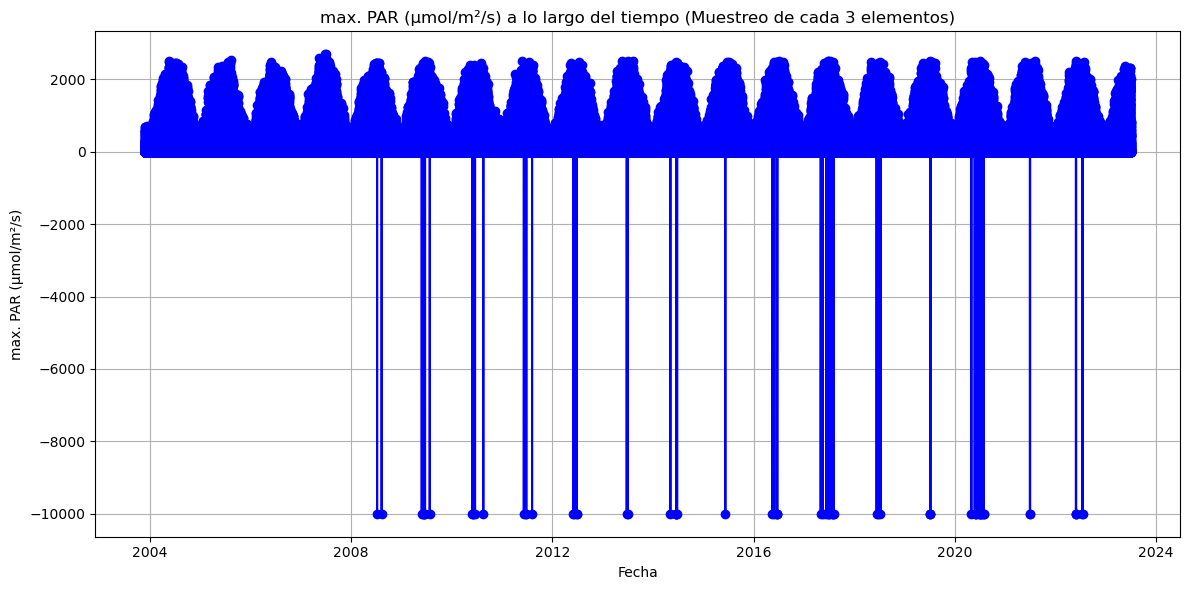

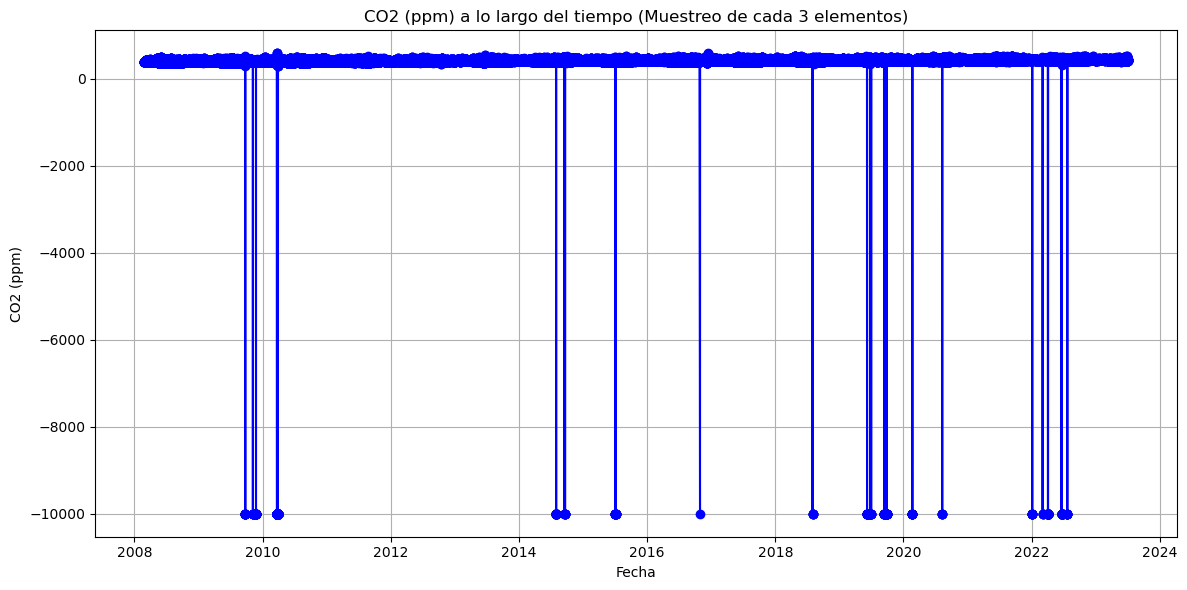

In [7]:
# Establecer la columna de fecha y hora como el índice del DataFrame
data.set_index(date_column, inplace=True)

# Realizar el muestreo cada 3 elementos
data_sampled = data.iloc[::3]

# Preparar los datos para graficar
columns_to_plot = ['T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'max. PAR (µmol/m²/s)', 'CO2 (ppm)']

# Crear gráficos separados para cada variable
for col in columns_to_plot:
    plt.figure(figsize=(12, 6))  # Tamaño del gráfico
    plt.plot(data_sampled.index, data_sampled[col], marker='o', linestyle='-', color='b')  # Graficar la serie temporal
    plt.title(f'{col} a lo largo del tiempo (Muestreo de cada 3 elementos)')  # Título del gráfico
    plt.xlabel('Fecha')  # Etiqueta del eje x
    plt.ylabel(col)  # Etiqueta del eje y
    plt.grid(True)  # Activar cuadrícula
    plt.tight_layout()  # Ajustar diseño
    plt.show()  # Mostrar gráfico

Los valores nulos principalmente estan en la parte de CO2, pero esto se debe a que es un valor que se comenzó a tomar en 2008, a diferencia del resto de muestras, que son de 2003 en adelante.

In [8]:
data_sampled.isnull().sum()

p (mbar)                    0
T (degC)                    0
Tpot (K)                    0
Tdew (degC)                 0
rh (%)                      0
VPmax (mbar)                0
VPact (mbar)                0
VPdef (mbar)                0
sh (g/kg)                   0
H2OC (mmol/mol)             0
rho (g/m**3)                0
wv (m/s)                    0
max. wv (m/s)               0
wd (deg)                    0
rain (mm)                   0
raining (s)                 0
SWDR (W/m²)                 0
PAR (µmol/m²/s)             0
max. PAR (µmol/m²/s)        0
Tlog (degC)                 0
CO2 (ppm)               74430
dtype: int64

Veamos pues esta relación a primera vista entre features

Text(0.5, 1.0, 'Correlation of columns in the dataframe')

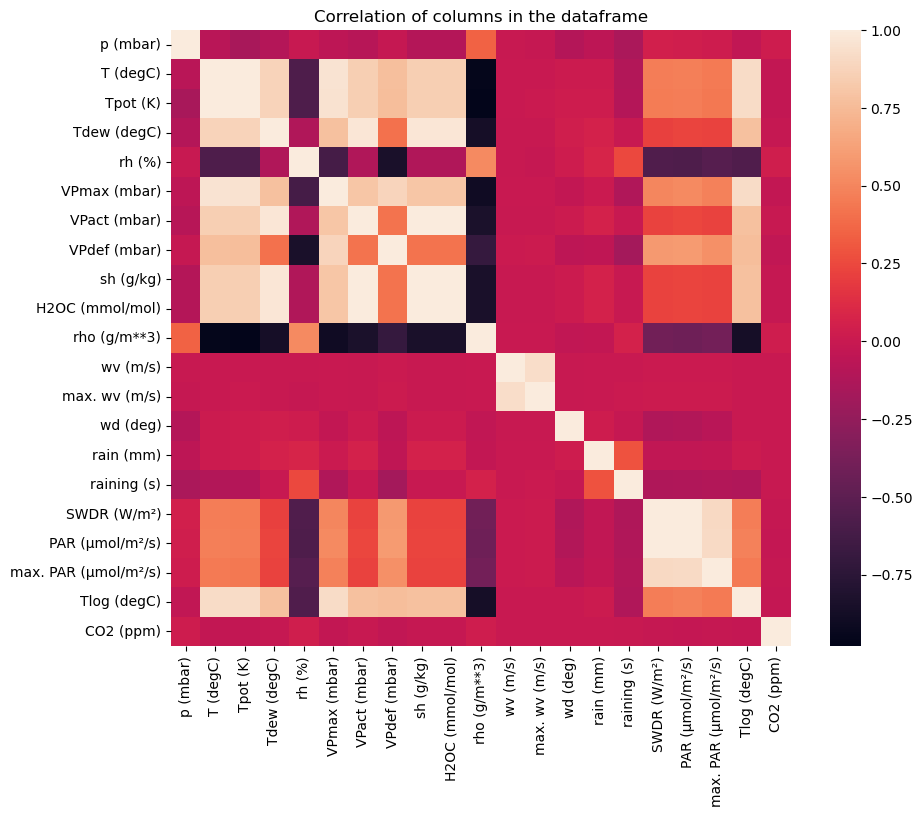

In [11]:
relacion = data_sampled.corr()

plt.figure(figsize=(10,8))
sns.heatmap(data=relacion)
plt.title("Correlation of columns in the dataframe")

Algo muy interesante que se puede tambien ver a raiz de este heatmap es la relacion entre temperatura y humedad relativa. Para estudiarlo con un grafico de regresion, primero pasaremos los datos a media mensual, ya que usar todos los datos para esto es computacionalmente costoso y en realidad no es necesario.

In [12]:
df_col = ['T (degC)', 'rh (%)']
df_monthly_mean = data[df_col].resample("MS").mean()
df_monthly_mean.head()

,T (degC),rh (%)
Date Time,,
2003-11-01,6.502879,91.194802
2003-12-01,1.752823,80.862845
2004-01-01,-0.095753,82.283342
2004-02-01,3.038716,74.977050
2004-03-01,4.424801,70.927204


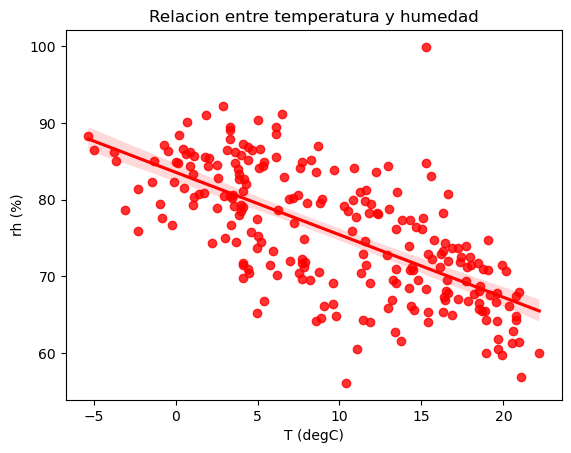

In [13]:
sns.regplot(data=df_monthly_mean, x="T (degC)", y="rh (%)", color="r")
plt.title("Relacion entre temperatura y humedad")
# save the figure
plt.show()

Queda tal que así, es decir, a mayor humedad, menor temperatura. Y a mayor temperatura, menor es la humedad.

Es el momento de ver ahora un grafico con las temperaturas medias de esta estacion a lo largo de los años, lo cual nos ayudará a tener una vision general de como evoluciona o si tenemos alguna anomalia a la que tengamos que prestarle especial atención

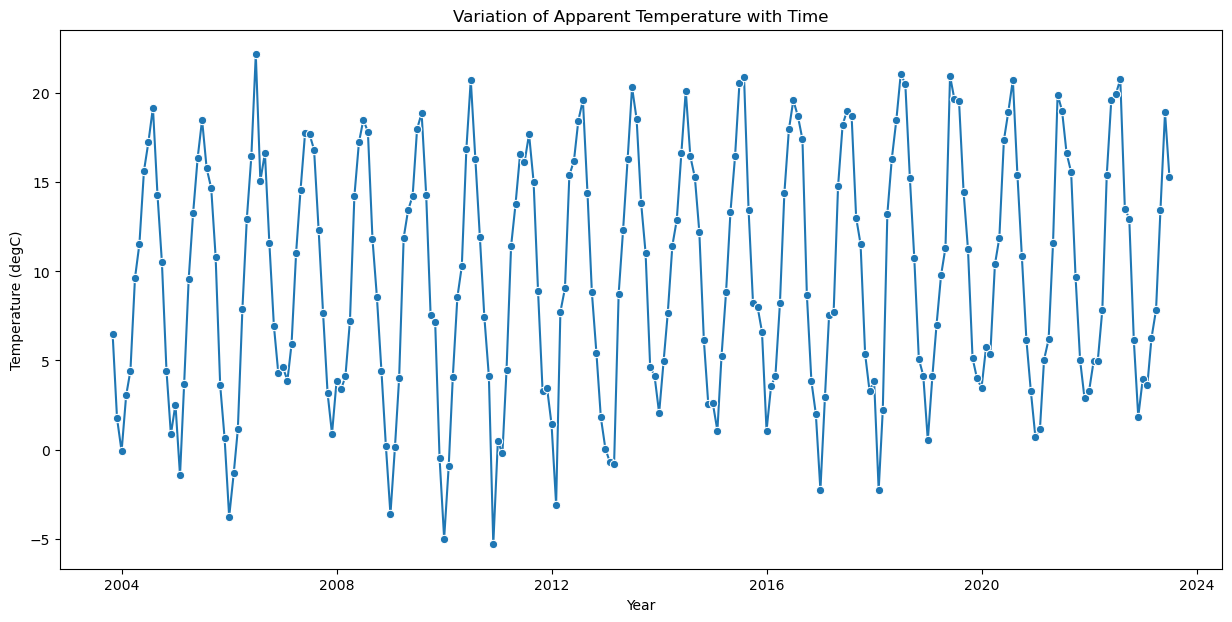

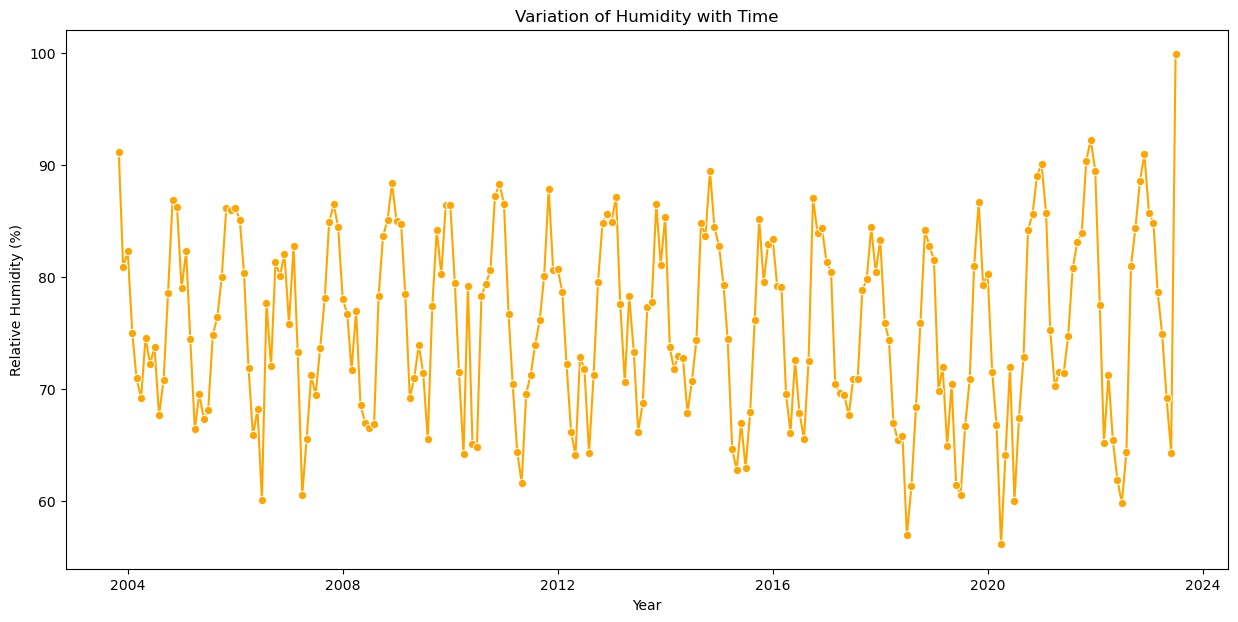

In [15]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_monthly_mean['T (degC)'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Temperature (degC)')
plt.title('Variation of Apparent Temperature with Time')
plt.savefig('temperature_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico para la Humedad Relativa
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_monthly_mean['rh (%)'], marker='o', linestyle='-', color='orange')
plt.xlabel('Year')
plt.ylabel('Relative Humidity (%)')
plt.title('Variation of Humidity with Time')
plt.savefig('humidity_plot.png', dpi=300, bbox_inches='tight')
plt.show()

Y de esta forma forma queda un poco mas extendido y es ams sencillo de ver (de cara a comparativas de años con respecto a meses)

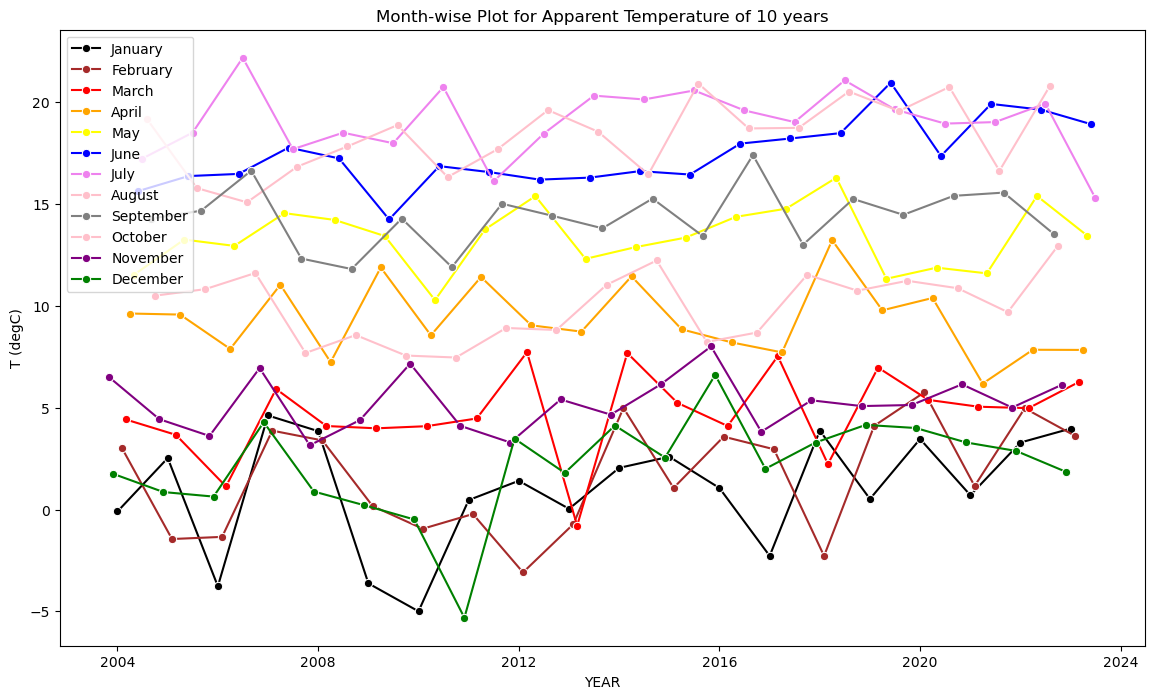

In [16]:
def label_color(month):
    if month == 1:
       return 'January','black'
    elif month == 2:
       return 'February','brown'
    elif month == 3:
       return 'March','red'
    elif month == 4:
       return 'April','orange'
    elif month == 5:
       return 'May','yellow'
    elif month == 6:
       return 'June','blue'
    elif month == 7:
       return 'July','violet'
    elif month == 8:
       return 'August','pink'
    elif month == 9:
       return 'September','grey'
    elif month == 10:
       return 'October','pink'
    elif month == 11:
       return 'November','purple'
    else:
       return 'December','green'
# Assigning variables to resampled data
TEMP_DATA = df_monthly_mean.iloc[:,0]
HUM_DATA = df_monthly_mean.iloc[:,1]
def plot_month(month, data):
    label, color = label_color(month)
    mdata = data[data.index.month == month]
    sns.lineplot(data=mdata,label=label,color=color,marker='o')
def sns_plot(title, data):
    plt.figure(figsize=(14,8))
    plt.title(title)
    plt.xlabel('YEAR')
    for i in range(1,13):
        plot_month(i,data)
    plt.savefig('plot4.png', dpi=300, bbox_inches='tight')
    plt.show()
# Month-wise Plot for Apparent Temperature of 10 years 
title = 'Month-wise Plot for Apparent Temperature of 10 years' 
sns_plot(title, TEMP_DATA)

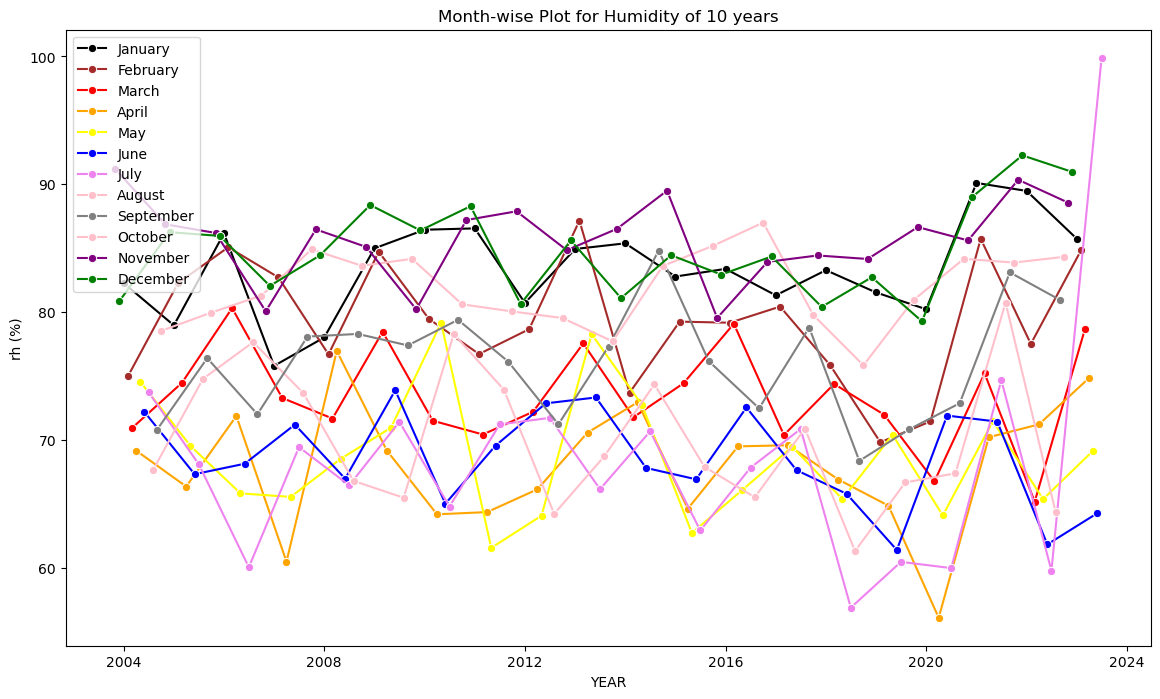

In [17]:
title = 'Month-wise Plot for Humidity of 10 years' 
sns_plot(title, HUM_DATA)

Esta es la forma de verlo por meses, sindo la deconstruccion en meses de las graficas anteriores y la combinacion entre temperatura y humedad para ambos en un mismo grafico

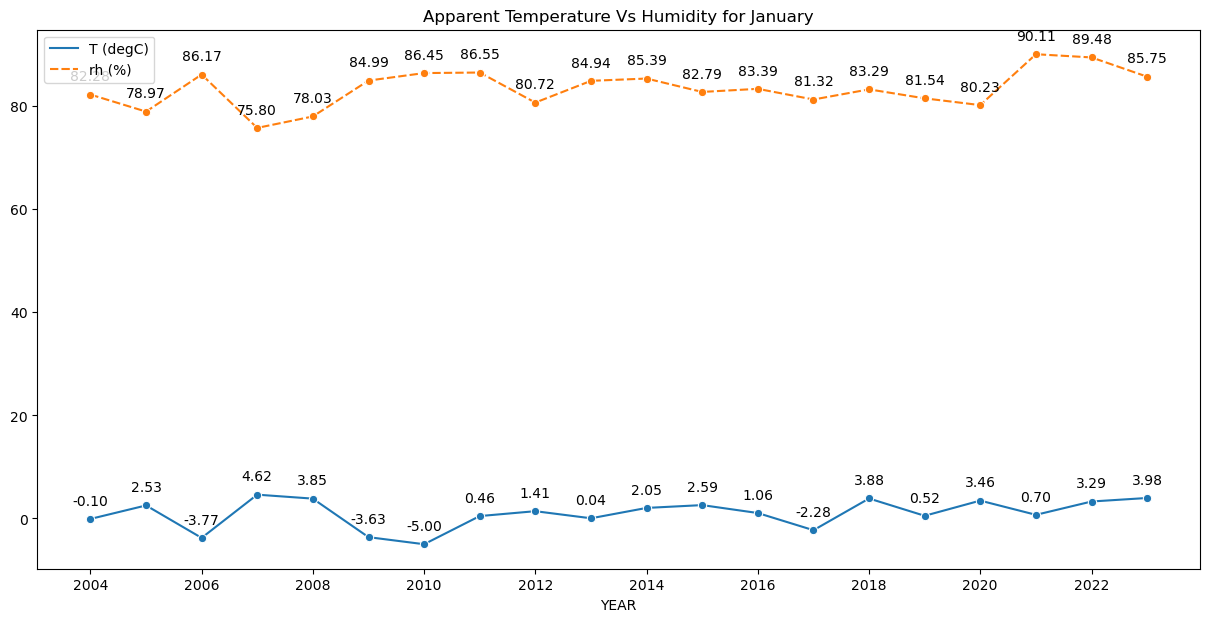

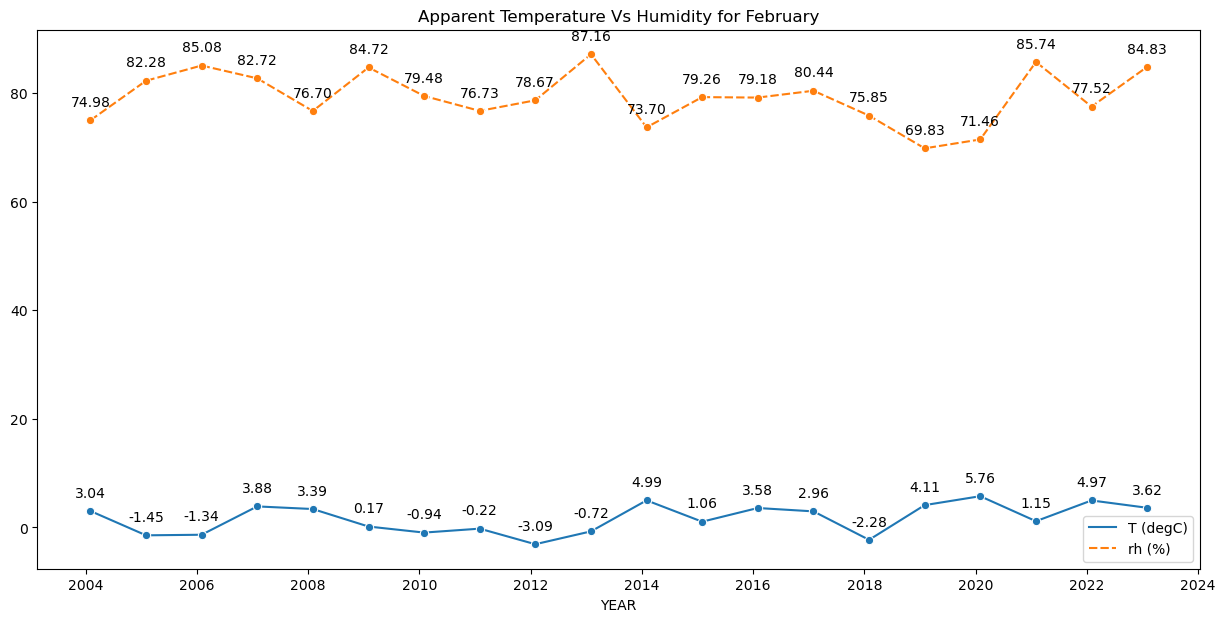

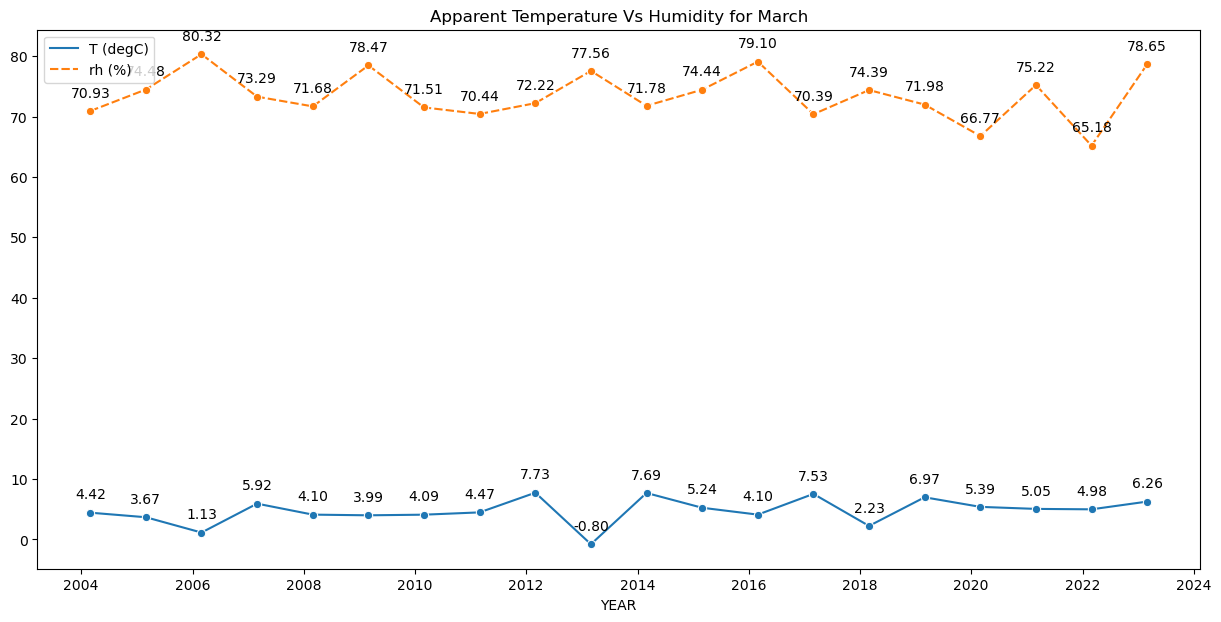

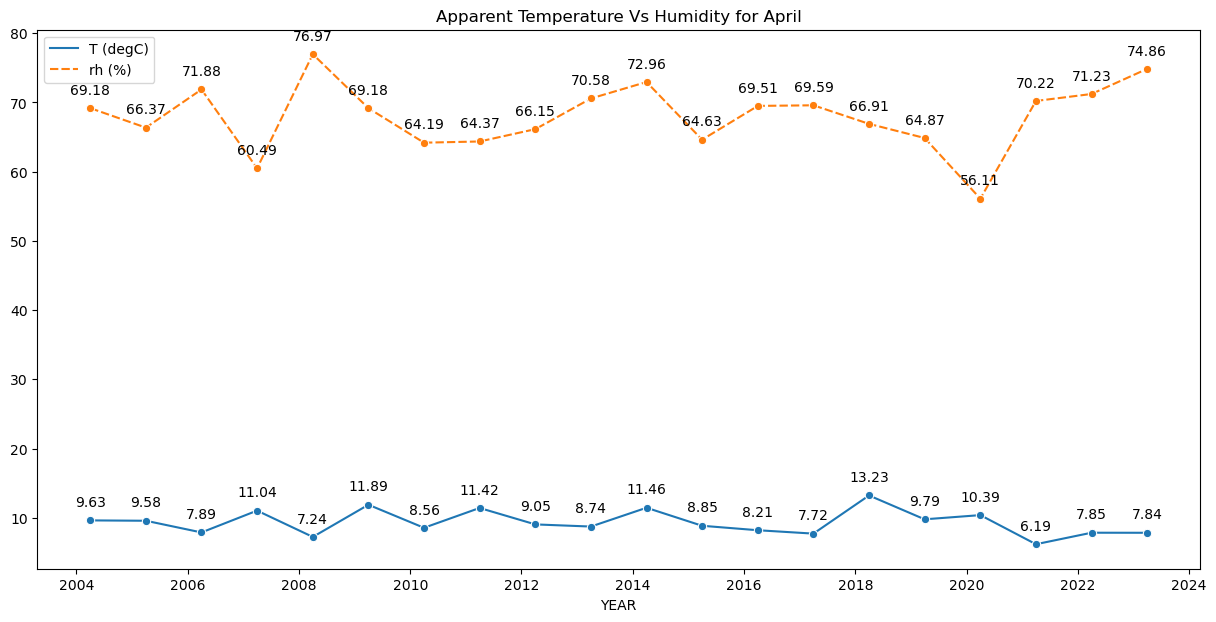

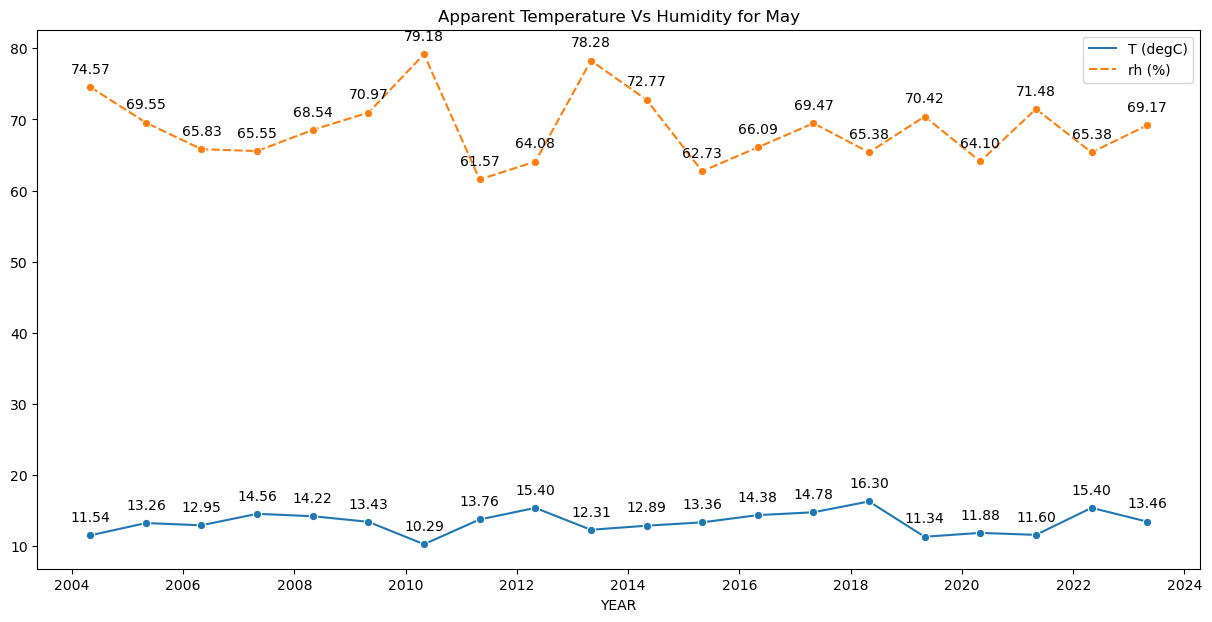

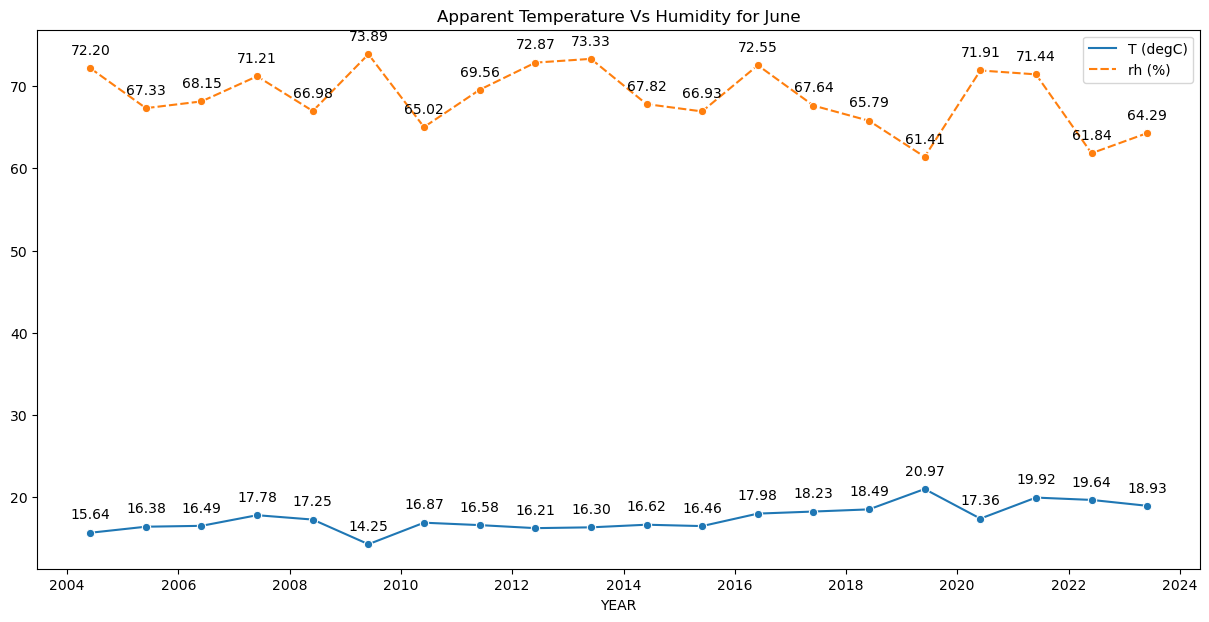

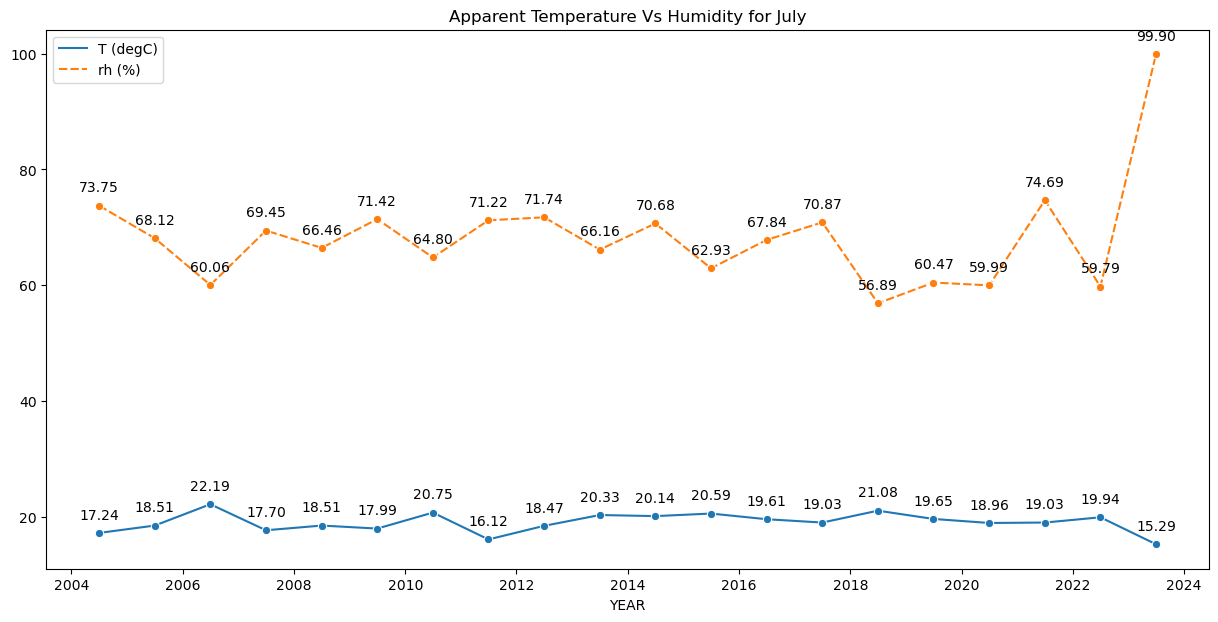

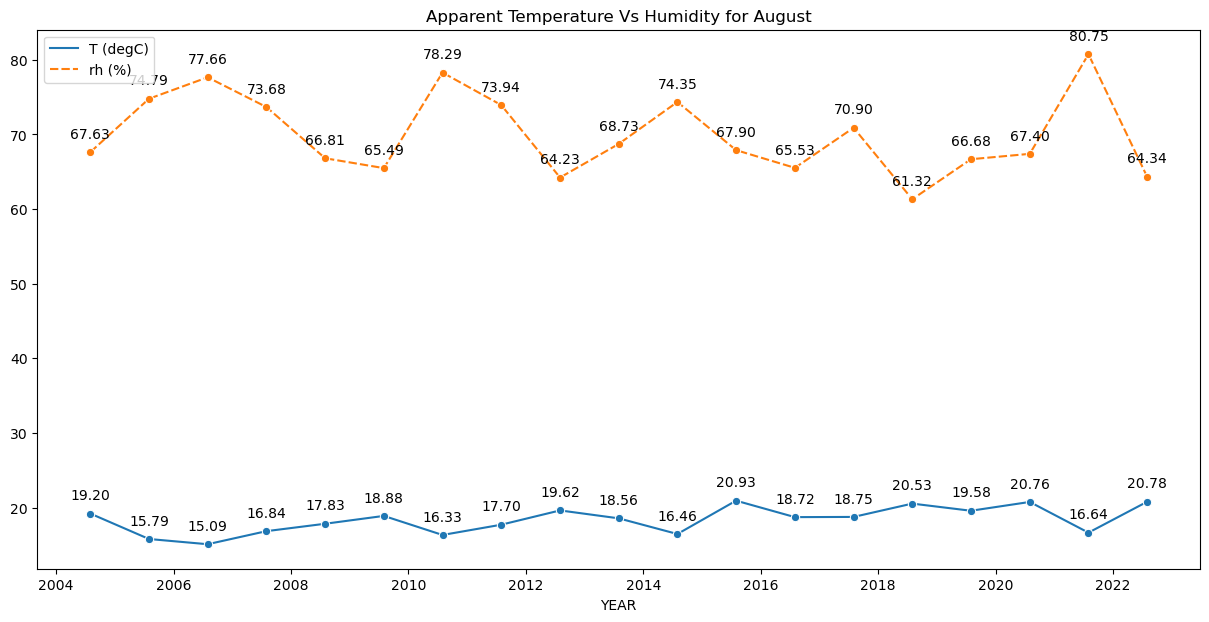

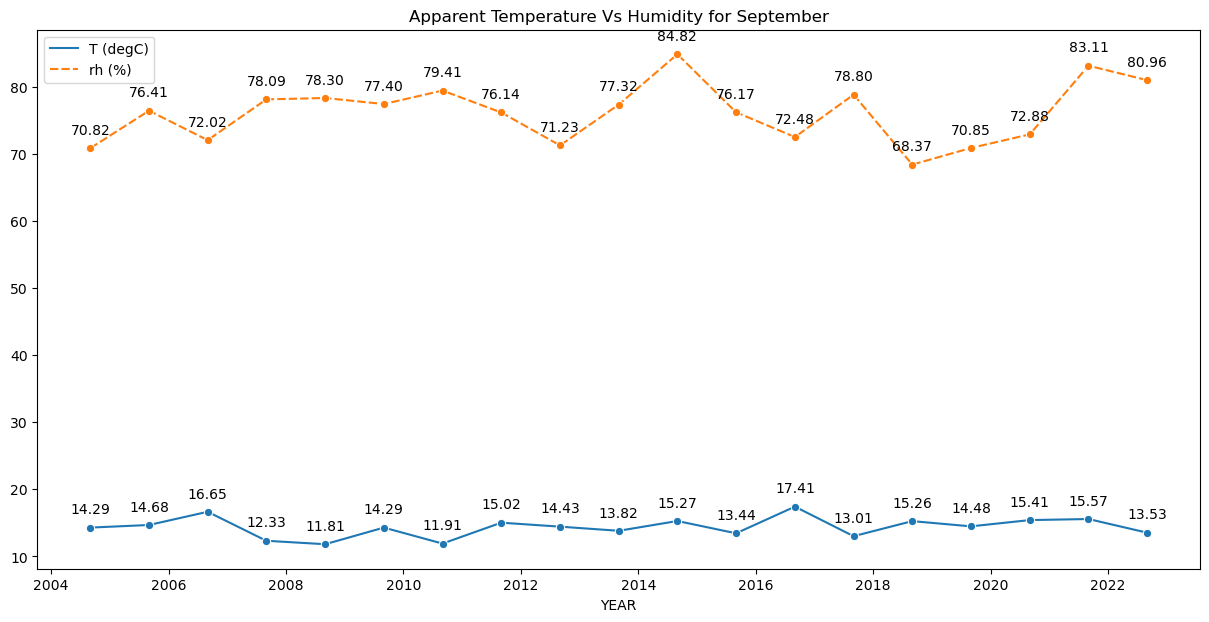

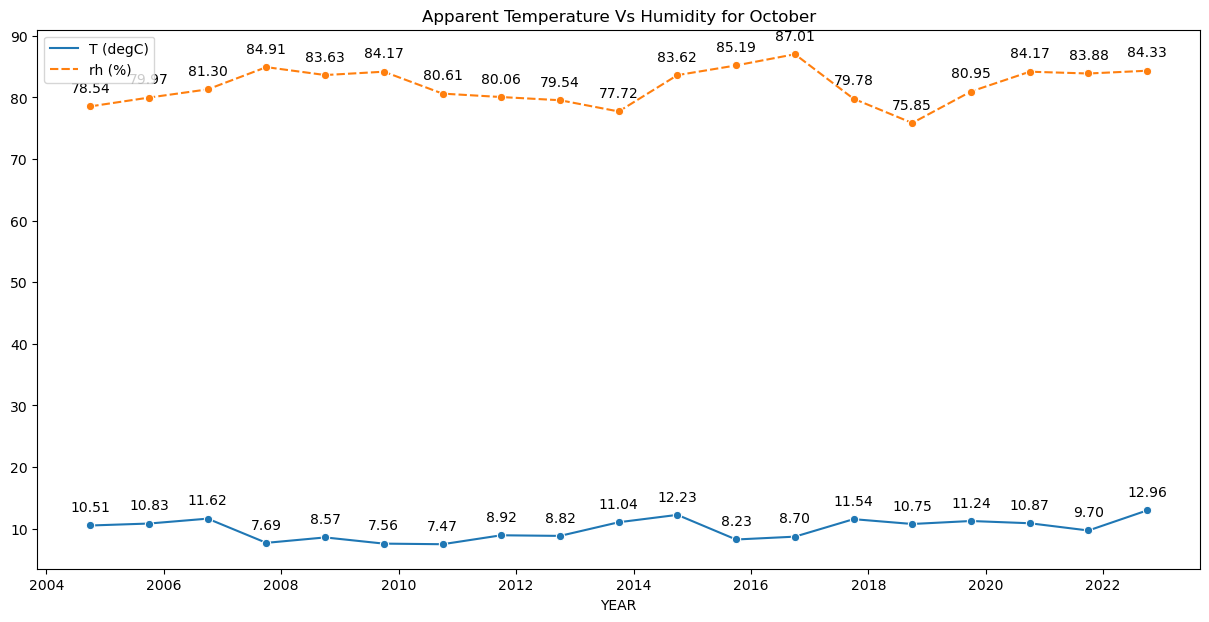

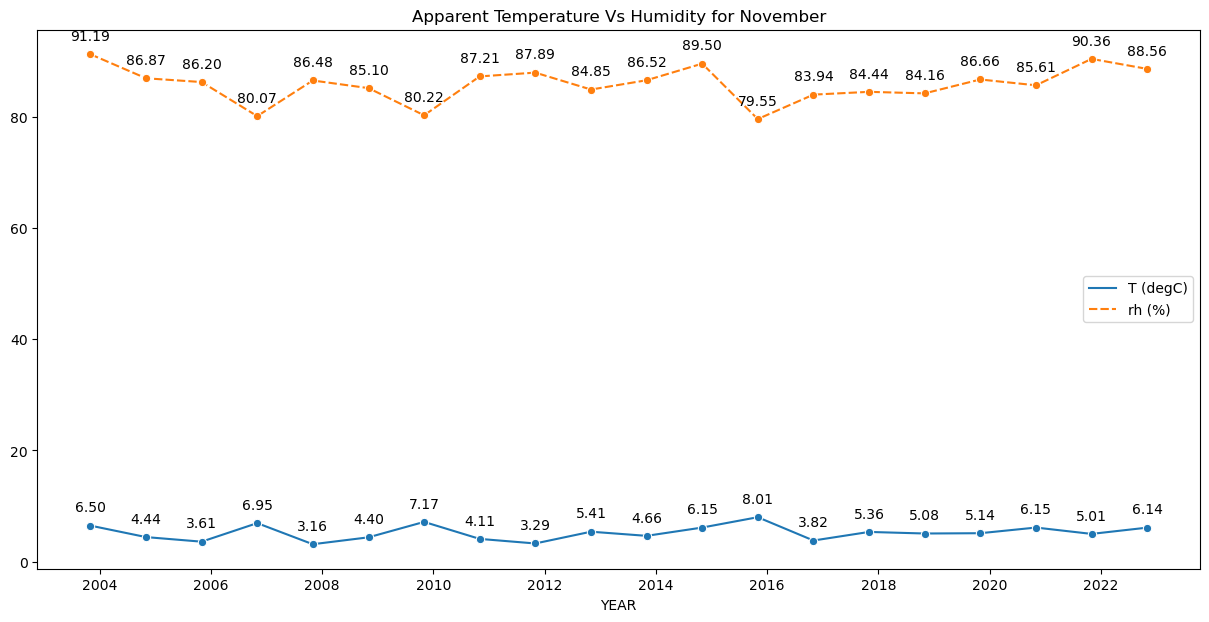

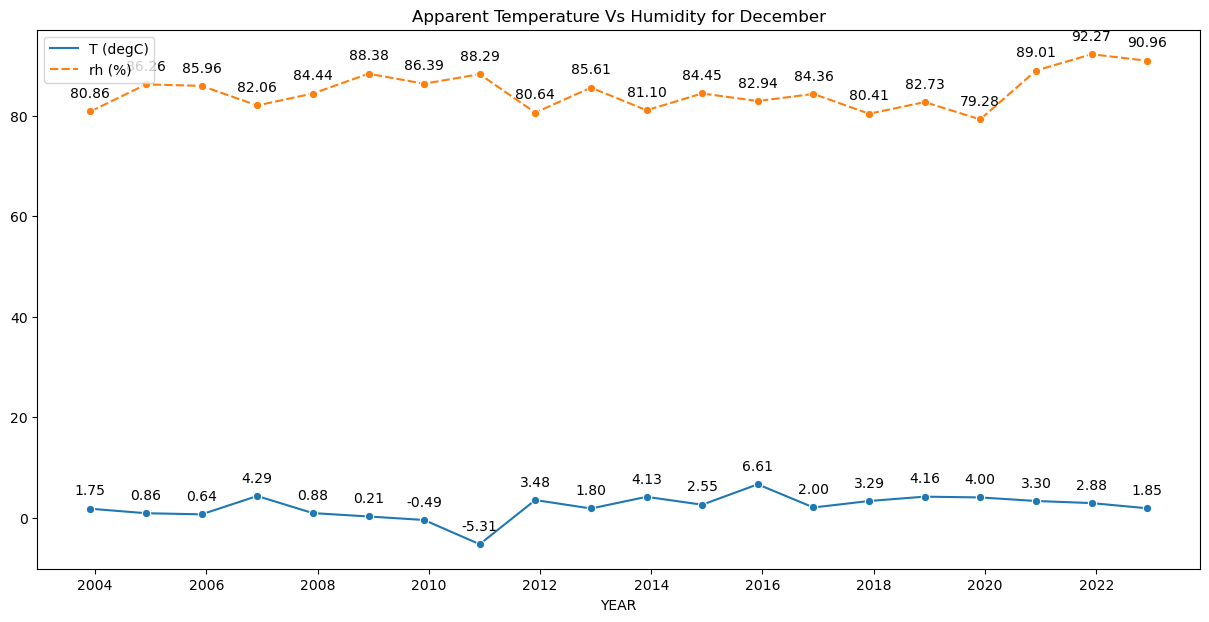

In [18]:
def label_color(month):
    # Esta función debe devolver el nombre del mes y un color para la línea, por ejemplo:
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange', 'pink', 'purple', 'grey']
    return (months[month-1], colors[month-1])

def sns_month_plot(month):
    plt.figure(figsize=(15, 7))
    label, color = label_color(month)
    plt.title('Apparent Temperature Vs Humidity for {}'.format(label))
    data = df_monthly_mean[df_monthly_mean.index.month == month]
    plt.xlabel('YEAR')
    
    sns.lineplot(data=data, marker='o', color=color)
    
    for col in data.columns:
        for x, y in zip(data.index, data[col]):
            plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
    
    name = f"month{month}.png"
    plt.savefig(name, dpi=300, bbox_inches='tight')
    plt.show()

# Plot for the month of 'January - December'
for month in range(1, 13):
    sns_month_plot(month)

Este es un error del que me he dado cuenta al realizar el notebook final, y que posiblemente sea un error que he arrastrado hasta el final del entrenamiento, pero en la limpieza de datos que he realizado en todas las iteraciones y el dataset que he usado, he dejado sin limpiar las dos columnas mencionadas en esta parte de codigo, ya que en principio no las iba a usar (luego si que las use).
El caso es que algunos periodos de los datos de este dataset tienen valores registrados de -9999, y asumo que es porque el sensor que recogía los datos no funcionaba correctamente, lo cual podria tener sentido. El caso es que esos periodos en los que se han tomado datos con esos valores han sido eliminados, ya que he preferido que hubiera un pequeño espacio en el tiempo a tener que lidiar con esos numeros.

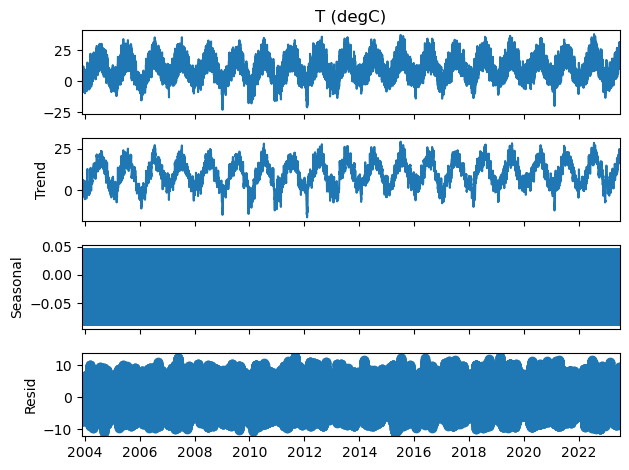

In [20]:
columns_to_check = [col for col in data.columns if col not in ['max. PAR (µmol/m²/s)', 'CO2 (ppm)']]
data[columns_to_check] = data[columns_to_check].apply(pd.to_numeric, errors='coerce')  # Convertir a numérico y manejar errores

# Eliminar filas con valores por debajo de -8000 en cualquier columna excepto 'max. PAR (µmol/m²/s)' y 'CO2 (ppm)'
data_cleaned = data[(data[columns_to_check] > -8000).all(axis=1)]
# Suponiendo que 'data_cleaned' tiene un índice de tiempo
result = seasonal_decompose(data_cleaned['T (degC)'], model='additive', period=365)
result.plot()
plt.show()

Lo siguiente que podemos sacar el la maxima deconstruccion de cara a la simplificacion de datos en esta serie temporal, y es hacer la media anual.

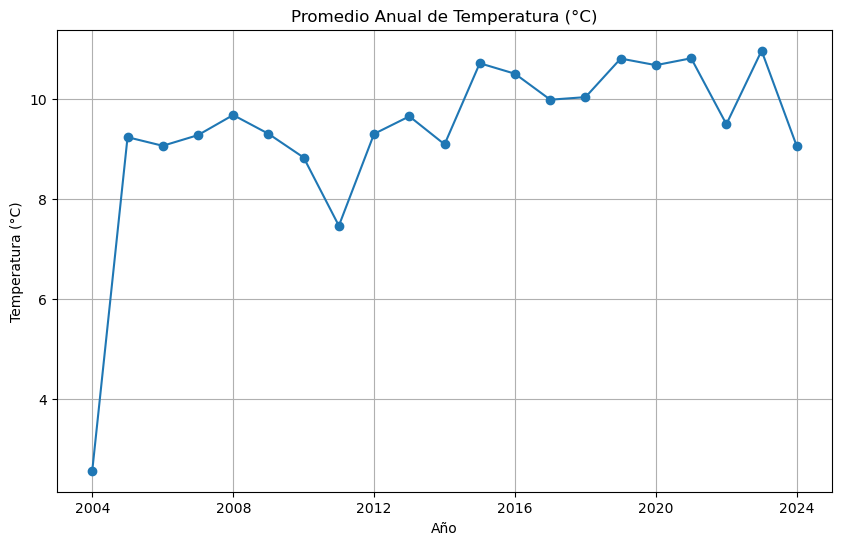

In [21]:
annual_mean = data_cleaned.resample('A').mean()

# Graficar el promedio anual
plt.figure(figsize=(10, 6))
plt.plot(annual_mean.index, annual_mean['T (degC)'], marker='o', linestyle='-')
plt.title('Promedio Anual de Temperatura (°C)')
plt.xlabel('Año')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.show()

Aqui se pueden ver los valores atipicos para estos años y como ha ido evolucionando (es importante recalcar que 2023 tiene la mitad del año, será mas importante de cara a uno de los graficos que vienen a continuacion)

C:\Users\unais\AppData\Local\Temp\ipykernel_6008\2352386498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Year'] = data_cleaned.index.year


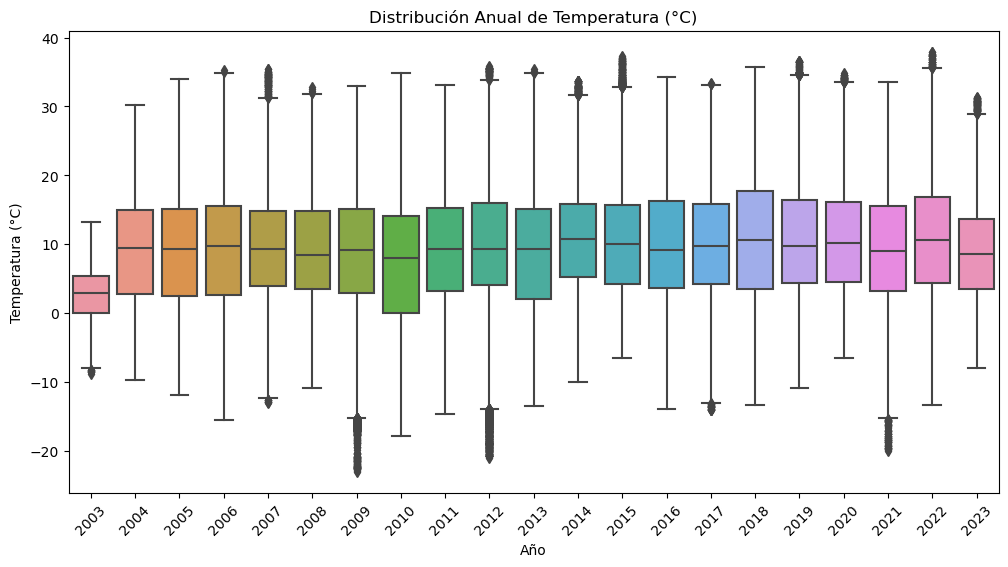

In [22]:
data_cleaned['Year'] = data_cleaned.index.year

# Crear boxplot anual
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='T (degC)', data=data_cleaned)
plt.title('Distribución Anual de Temperatura (°C)')
plt.xlabel('Año')
plt.ylabel('Temperatura (°C)')
plt.xticks(rotation=45)
plt.show()

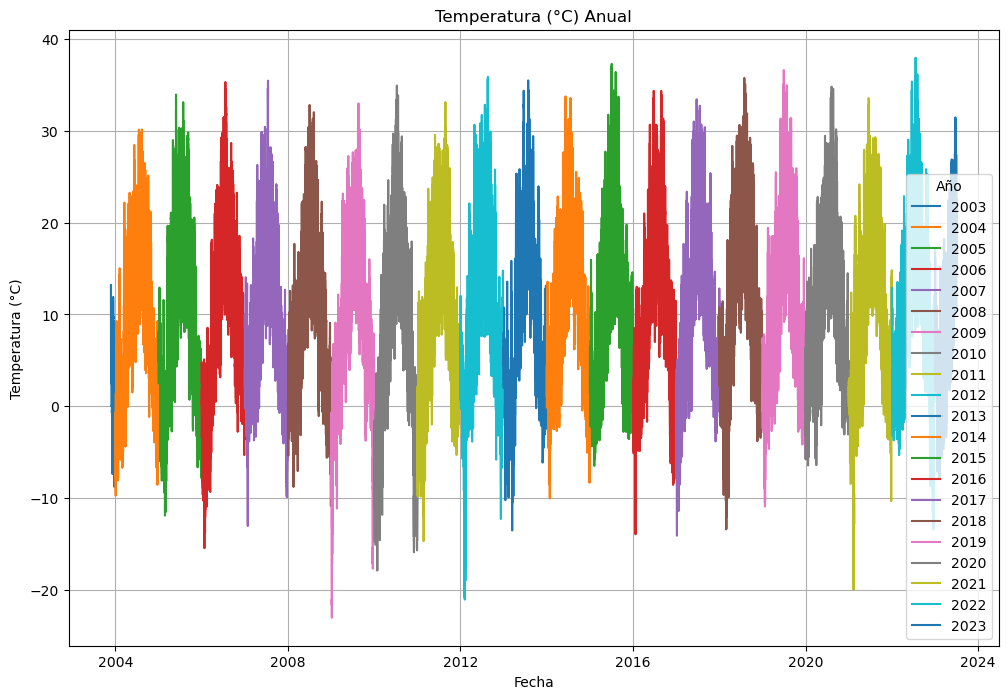

In [23]:
plt.figure(figsize=(12, 8))
for year in data_cleaned['Year'].unique():
    yearly_data = data_cleaned[data_cleaned['Year'] == year]
    plt.plot(yearly_data.index, yearly_data['T (degC)'], label=year)

plt.title('Temperatura (°C) Anual')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend(title='Año')
plt.grid(True)
plt.show()

En este grafico interactivo se pueden ver las medias mensuales por año y ayuda a que estas medias entren por los ojos de una forma mas sencilla y clara, ayudando a ver donde hay meses con medias mas inusuales o fuera de lo que se espera o es lo comun

In [24]:
import plotly.express as px

# Asegurarse de que 'data_cleaned' ya está definido
data_cleaned = data_cleaned.copy()
data_cleaned['Month'] = data_cleaned.index.month
data_cleaned['Year'] = data_cleaned.index.year

# Crear tabla pivote para el heatmap
pivot_table = data_cleaned.pivot_table(values='T (degC)', index='Month', columns='Year', aggfunc='mean')

# Graficar el heatmap con Plotly
fig = px.imshow(pivot_table, text_auto=True, aspect="auto", color_continuous_scale='Turbo', labels=dict(x="Mes", y="Año", color="Temperature (°C)"))
fig.update_layout(title='Heatmap de Temperatura (°C) por Año y Mes')
fig.show()

Y ahora, dos de las graficas que nos ayudan a ver como se desarrollan las temperaturas a lo largo del tiempo. Cada punto representa la media de cada mes y la linea roja representa la tendencia de la temperatura. Como puede verse, esta sube dos grados aproximadamente en un lapso de 20 años.

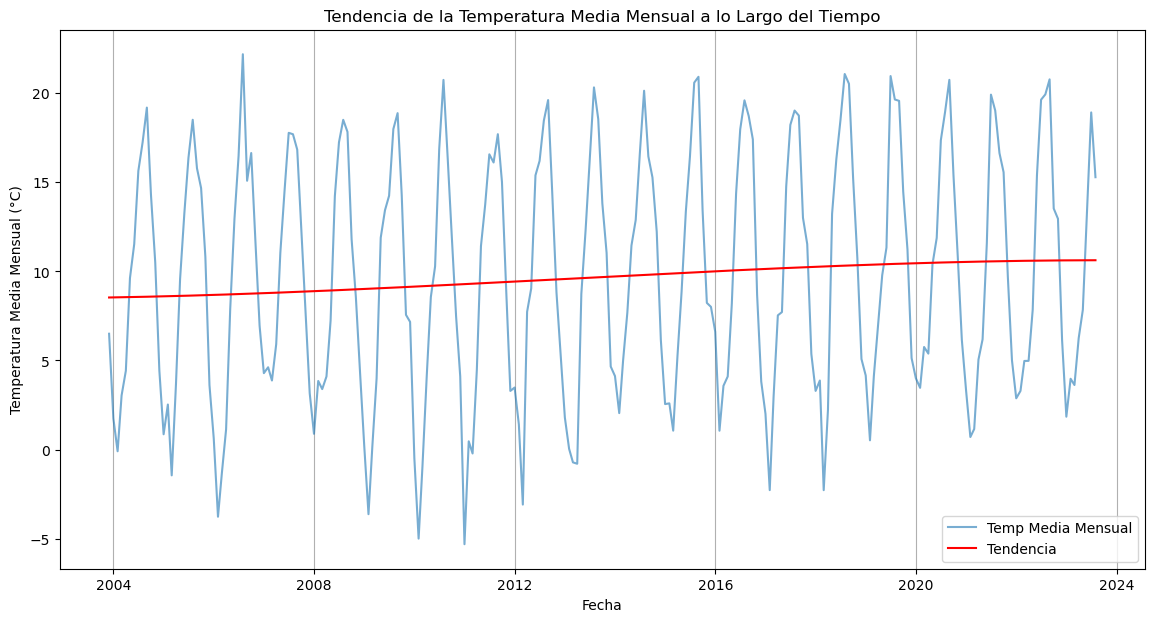

,T (degC),Trend
Date Time,,
2003-11-30,6.502879,8.537464
2003-12-31,1.752823,8.541536
2004-01-31,-0.095753,8.545761
2004-02-29,3.038716,8.550138
2004-03-31,4.424801,8.554665
...,...,...
2023-03-31,6.260249,10.625653
2023-04-30,7.840445,10.626669
2023-05-31,13.460224,10.627504


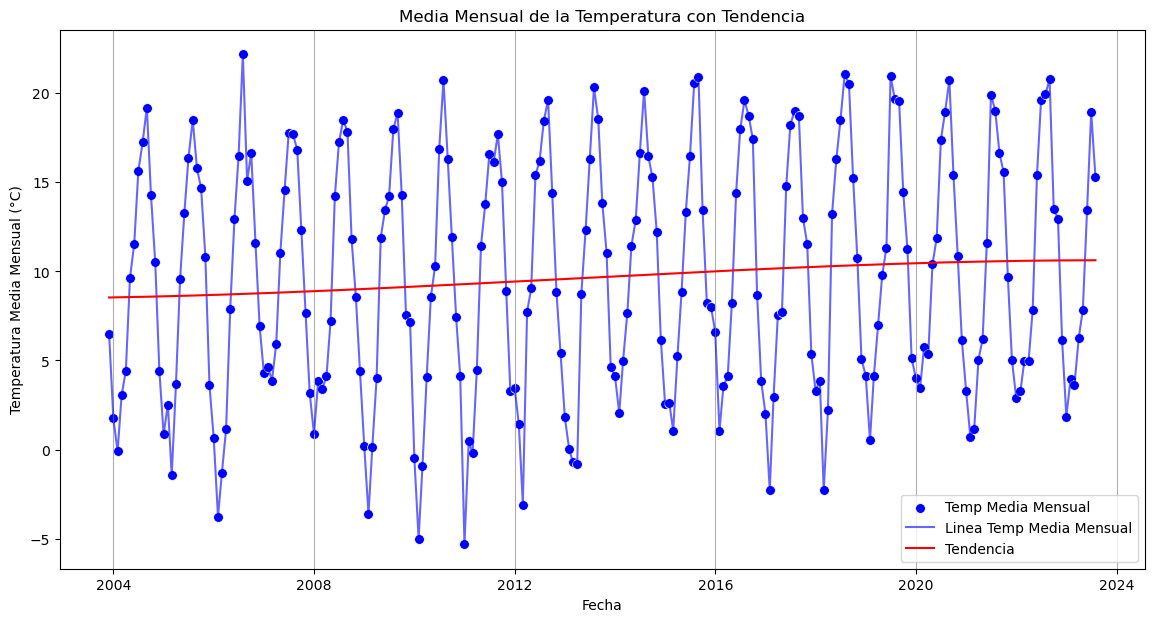

In [27]:
def get_trend(timeseries, deg=3):
    """Crear una línea de tendencia para datos de series temporales

    Args:
        timeseries (pd.Series): datos de series temporales
        deg (int): grado del polinomio para la línea de tendencia

    Returns:
        pd.Series: línea de tendencia
    """
    x = list(range(len(timeseries)))
    y = timeseries.values
    coef = np.polyfit(x, y, deg)
    trend = np.poly1d(coef)(x)
    return pd.Series(data=trend, index=timeseries.index)


temp_column = 'T (degC)'  # Cambiar esto si el nombre de la columna es diferente

# Asegurarse de que la columna de temperatura existe
if temp_column not in data_cleaned.columns:
    raise KeyError(f"La columna '{temp_column}' no se encontró en el DataFrame.")

# Calcular la media mensual de la temperatura
data_monthly = data_cleaned[temp_column].resample('M').mean()

# Calcular la tendencia de la media mensual
data_monthly = data_monthly.to_frame(name=temp_column)  # Convertir a DataFrame
data_monthly['Trend'] = get_trend(data_monthly[temp_column])

# Crear la figura para la gráfica de la serie temporal y la tendencia
fig1, ax1 = plt.subplots(figsize=(14, 7))

# Graficar la serie temporal y la tendencia de la media mensual
sns.lineplot(x=data_monthly.index, y=data_monthly[temp_column], ax=ax1, alpha=0.6, label='Temp Media Mensual')
sns.lineplot(x=data_monthly.index, y=data_monthly['Trend'], ax=ax1, label='Tendencia', color='red')

# Configurar la gráfica
ax1.set_title('Tendencia de la Temperatura Media Mensual a lo Largo del Tiempo')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Temperatura Media Mensual (°C)')
ax1.grid(axis='x')
ax1.legend()

# Mostrar la gráfica
plt.show()

# Mostrar la tabla con los valores medios mensuales y la tendencia
display(data_monthly)

# Crear la figura para la gráfica de puntos y la tendencia
fig2, ax2 = plt.subplots(figsize=(14, 7))

# Graficar la media mensual con puntos, línea y la tendencia
sns.scatterplot(x=data_monthly.index, y=data_monthly[temp_column], ax=ax2, label='Temp Media Mensual', color='blue', s=50)
sns.lineplot(x=data_monthly.index, y=data_monthly[temp_column], ax=ax2, alpha=0.6, label='Linea Temp Media Mensual', color='blue')
sns.lineplot(x=data_monthly.index, y=data_monthly['Trend'], ax=ax2, label='Tendencia', color='red')

# Configurar la gráfica
ax2.set_title('Media Mensual de la Temperatura con Tendencia')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Temperatura Media Mensual (°C)')
ax2.grid(axis='x')
ax2.legend()

# Mostrar la gráfica de puntos y la tendencia
plt.show()

Ahora, una vez se ha hecho el analisis de los datos que tenemos disponibles, pasamos a entrenar el modelo

# Entrenamiento de modelo

Leemos el csv que hemos dejado 'limpio' anteriormente y definimos la funcion que nos ayudará con la normalizacion de los datos.
Los parametros que están definidos es mejor no hacerles caso de momento, ya que se usarán mas adelante, pero sabed que estan aqui definidos y que puede que se redefinan mas adelante.

In [29]:
csv_file = 'Beuten_cleaned.csv'
df = pd.read_csv(csv_file, sep=r',\s*', engine='python')

# Definir parámetros y configuración
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 3
past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 15
date_column = 'Date Time'

# Función para normalizar los datos
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

Definimos las features y su normalizacion para el entrenamiento.

In [30]:
feature_keys = [
    "p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)",
    "VPmax (mbar)", "VPact (mbar)", "VPdef (mbar)", "sh (g/kg)",
    "H2OC (mmol/mol)", "rho (g/m**3)", "wv (m/s)", "max. wv (m/s)",
    "wd (deg)", "rain (mm)"
]

# Imprimir columnas del DataFrame
print("Columnas del DataFrame:", df.columns)

# Imprimir características seleccionadas

# Seleccionar características y normalizar
selected_features = [feature_keys[i] for i in [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14]]
features = df[selected_features]
features.index = pd.to_datetime(df[date_column])
""" features = normalize(features.values, train_split) """
features = pd.DataFrame(features)

Columnas del DataFrame: Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)',
       'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)', 'CO2 (ppm)'],
      dtype='object')


Preparamos el conjunto de datos de train y de validacion para el entrenamiento

In [31]:
# Separar datos de entrenamiento y validación
train_data = features.iloc[0:train_split]
val_data = features.iloc[train_split:]

# Preparar datos para el modelo
start = past + future
end = start + train_split
x_train = train_data[selected_features].values
y_train = features.iloc[start:end]['T (degC)'].values

sequence_length = int(past / step)

# Crear conjunto de datos de entrenamiento
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [32]:
# Preparar datos de validación para el modelo
x_end = len(val_data) - past - future
label_start = train_split + past + future
x_val = val_data[selected_features].iloc[:x_end].values
y_val = features.iloc[label_start:]['T (degC)'].values

# Crear conjunto de datos de validación
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


Definimos la estructura del modelo

In [33]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
# Definir el modelo LSTM
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(64, return_sequences=True)(inputs)
lstm_out = keras.layers.LSTM(64)(lstm_out)
dense_out = keras.layers.Dense(64, activation='relu')(lstm_out)
outputs = keras.layers.Dense(1)(dense_out)

# Crear el modelo
model = keras.Model(inputs=inputs, outputs=outputs)

# Compilar el modelo
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

# Resumen del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 240, 64)        │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,961 (222.50 KB)

 Trainable params: 56,961 (222.50 KB)

 Non-trainable params: 0 (0.00 B)

Aqui se entrena el modelo pero como no voy a ejecutar todo el entrenamiento de nuevo, ya que tarda bastante, cargaré el modelo mas adelante.
Para realizar el entrenamiento basta con descomentarlo y ejecutar todo.

In [ ]:
# Entrenar el modelo
""" history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
)

# Evaluar el modelo en datos de validación
val_loss = model.evaluate(dataset_val)
print(f'Loss en datos de validación: {val_loss}') """

Y esta es la parte de codigo con la que se guardó el modelo.

In [ ]:
""" model_filename = 'modelo_lstm_final_v1.keras'

# Guarda el modelo completo (arquitectura + pesos entrenados)
model.save(model_filename)

# Imprime un mensaje para confirmar que el modelo se ha guardado correctamente
print(f'Modelo guardado como {model_filename}') """

In [34]:
from tensorflow.keras.models import load_model
model_filename = 'modelo_lstm_final_v1.keras'
model = load_model(model_filename)

c:\Users\unais\anaconda3\envs\DataScience\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 



La primera de las predicciones que se realiza (son 10 predicciones a futuro) y como puede verse, el modelo realiza unas predicciones por debajo de las temperaturas que son las reales. No es del todo preciso pero se puede intuir que por lo menos algo de precisión tiene (no nos está dando una temperatura de 20 grados en diciembre, lo cual es positivo)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
-1.40264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
-1.6470455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.7956145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.8167298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-1.838636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.7873349
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.8034766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.8144008
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-1.8411598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.8647766


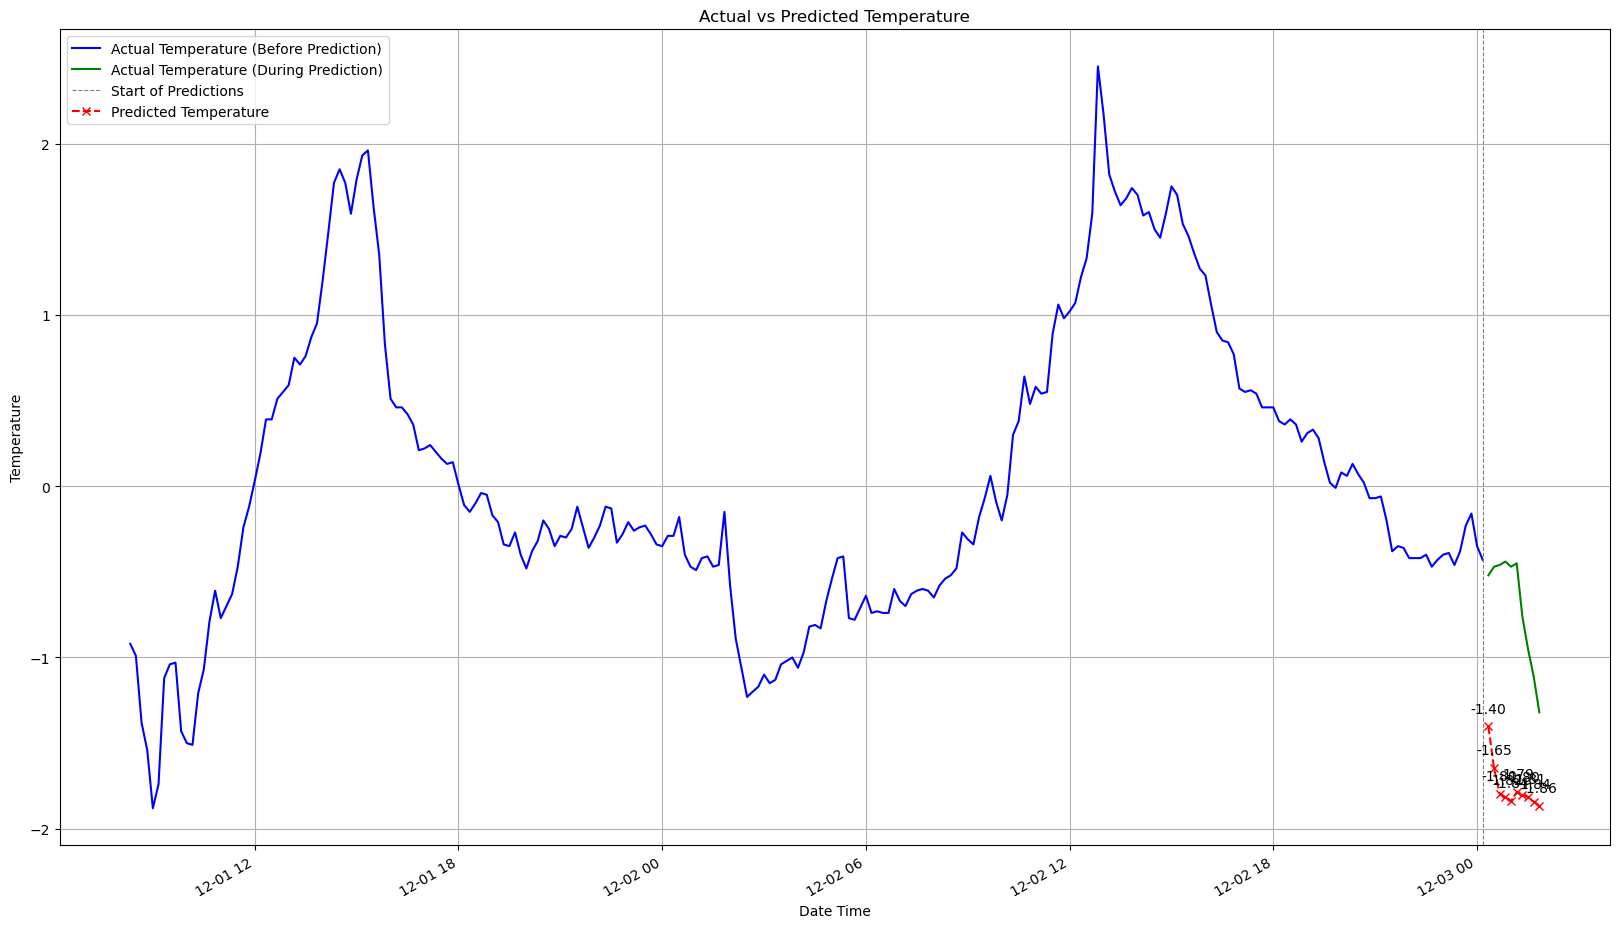

                 Date  Predicted Temperature  Actual Temperature
0 2017-12-03 00:20:00              -1.402640               -0.52
1 2017-12-03 00:30:00              -1.647045               -0.47
2 2017-12-03 00:40:00              -1.795614               -0.46
3 2017-12-03 00:50:00              -1.816730               -0.44
4 2017-12-03 01:00:00              -1.838636               -0.47
5 2017-12-03 01:10:00              -1.787335               -0.45
6 2017-12-03 01:20:00              -1.803477               -0.76
7 2017-12-03 01:30:00              -1.814401               -0.95
8 2017-12-03 01:40:00              -1.841160               -1.11
9 2017-12-03 01:50:00              -1.864777               -1.32


In [35]:
start_idx = 360
sequence_length = 240  # Número de pasos hacia el pasado (por ejemplo, 240 horas)
num_predictions = 10  # Número de predicciones futuras

if start_idx < sequence_length:
    raise ValueError(f'start_idx ({start_idx}) debe ser mayor o igual a sequence_length ({sequence_length})')

# Función para denormalizar los datos
def denormalize(data, mean, std):
    return data * std + mean

# Preparar datos de validación
x_val_last = val_data.iloc[start_idx - sequence_length:start_idx][selected_features].values.reshape((1, sequence_length, len(selected_features)))

# Crear listas para almacenar las predicciones y sus fechas
predicted_temperatures = []
predicted_dates = []
actual_temperatures = []

# Realizar predicciones secuenciales de la muestra 200 a la 210
for i in range(num_predictions):
    # Índice actual
    current_idx = start_idx + i
    
    # Realizar la predicción
    actual_temp = val_data['T (degC)'].iloc[current_idx]
    actual_temperatures.append(actual_temp)
    
    predicted_temp = model.predict(x_val_last)
    predicted_temp=predicted_temp.flatten()[0]
    """ predicted_temp = denormalize(predicted_temp.flatten()[0], data_mean[1], data_std[1]) """
    print(predicted_temp)
    # Añadir la predicción y la fecha correspondiente a las listas
    predicted_temperatures.append(predicted_temp)
    predicted_dates.append(val_data.index[current_idx])

    # Preparar las nuevas características de entrada para la próxima predicción
    new_feature_row = x_val_last[:, 1:, :]  # Descartar la fila más antigua
    
    new_feature = np.zeros((1, 1, len(selected_features)))
    new_feature[0, 0, 1:] = x_val_last[0, -1, 1:]  # Mantener las características excepto la primera
    new_feature[0, 0, 0] = predicted_temp  # Añadir la nueva predicción a la primera característica
    
    x_val_last = np.concatenate((new_feature_row, new_feature), axis=1)

# Obtener las fechas correspondientes a los datos de validación
dates_val = val_data.index[start_idx - sequence_length:start_idx + num_predictions]
y_val_truncated = val_data['T (degC)'].iloc[start_idx - sequence_length:start_idx + num_predictions]

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(20, 12))

# Trazar temperatura real antes del inicio de predicciones
ax.plot(dates_val[:sequence_length], y_val_truncated[:sequence_length], label='Actual Temperature (Before Prediction)', color='blue')

# Trazar temperatura real después del inicio de predicciones en verde
ax.plot(dates_val[sequence_length:], y_val_truncated[sequence_length:], label='Actual Temperature (During Prediction)', color='green')

# Trazar línea vertical para indicar inicio de predicciones
ax.axvline(x=dates_val[sequence_length - 1], linestyle='--', color='gray', linewidth=0.8, label='Start of Predictions')

# Trazar predicciones de temperatura con 'X' rojas
ax.plot(predicted_dates, predicted_temperatures, linestyle='--', color='red', marker='x', label='Predicted Temperature')

# Añadir anotaciones para las predicciones
for i, txt in enumerate(predicted_temperatures):
    ax.annotate(f'{txt:.2f}', (predicted_dates[i], predicted_temperatures[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Configurar etiquetas y título
ax.set_xlabel('Date Time')
ax.set_ylabel('Temperature')
ax.legend()
ax.set_title('Actual vs Predicted Temperature')
ax.grid(True)

# Rotar las fechas para mejor visualización
fig.autofmt_xdate()

# Mostrar gráfico
plt.show()

prediction_results = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted Temperature': predicted_temperatures,
    'Actual Temperature': actual_temperatures
})
print(prediction_results)

Si se amplia el espectro de las predicciones a 50, podemos ver que a pesar de que inicialmente las predicciones fueran un poco bajas con respecto a las reales, ha mejorado su interpretacion y ahora parece que se mantiene en un rango muy cercano a lo que debería ser. No las acierta del todo pero el error no es especialmente alto, o no lo considero tan alto como para considerarse una evaluacion negativa.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
-1.40264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.6470455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-1.7956145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-1.8167298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.838636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.7873349
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8034766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
-1.8144008
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8411598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8647766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8847215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
-1.8730712
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
-1.8936771
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8998849
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
-1.8803074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8777995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
-1.9086623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-1.99073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-2.0717938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-2.068499
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

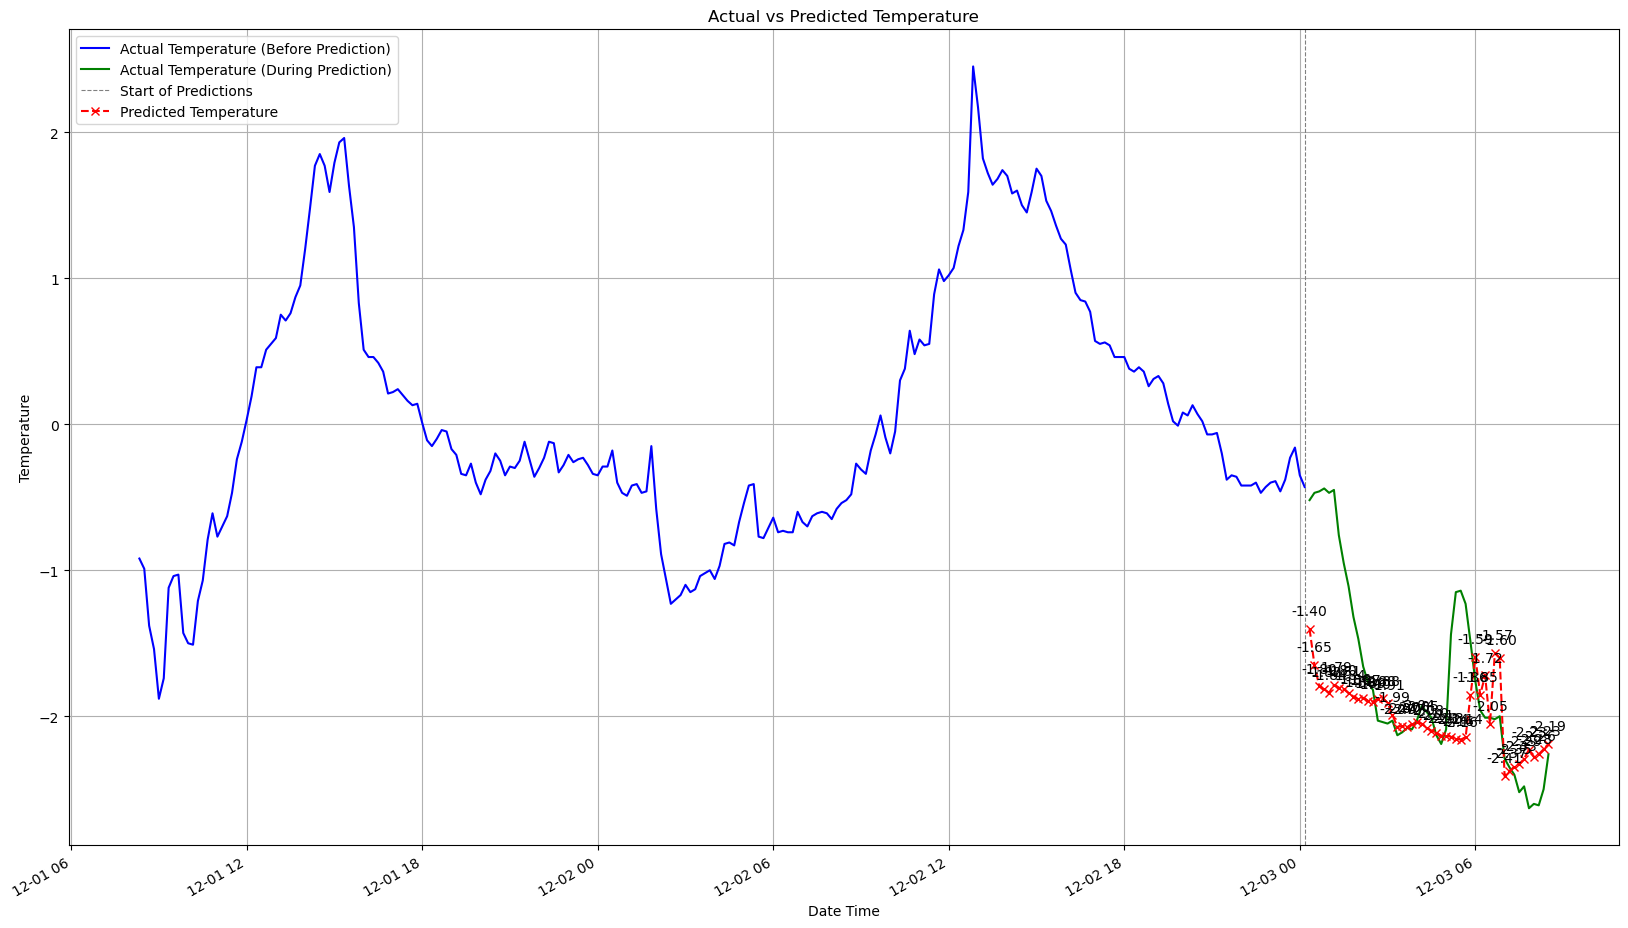

                  Date  Predicted Temperature  Actual Temperature
0  2017-12-03 00:20:00              -1.402640               -0.52
1  2017-12-03 00:30:00              -1.647045               -0.47
2  2017-12-03 00:40:00              -1.795614               -0.46
3  2017-12-03 00:50:00              -1.816730               -0.44
4  2017-12-03 01:00:00              -1.838636               -0.47
5  2017-12-03 01:10:00              -1.787335               -0.45
6  2017-12-03 01:20:00              -1.803477               -0.76
7  2017-12-03 01:30:00              -1.814401               -0.95
8  2017-12-03 01:40:00              -1.841160               -1.11
9  2017-12-03 01:50:00              -1.864777               -1.32
10 2017-12-03 02:00:00              -1.884722               -1.47
11 2017-12-03 02:10:00              -1.873071               -1.66
12 2017-12-03 02:20:00              -1.893677               -1.77
13 2017-12-03 02:30:00              -1.899885               -1.82
14 2017-12

In [36]:
start_idx = 360
sequence_length = 240  # Número de pasos hacia el pasado (por ejemplo, 240 horas)
num_predictions = 50  # Número de predicciones futuras

if start_idx < sequence_length:
    raise ValueError(f'start_idx ({start_idx}) debe ser mayor o igual a sequence_length ({sequence_length})')

# Función para denormalizar los datos
def denormalize(data, mean, std):
    return data * std + mean

# Preparar datos de validación
x_val_last = val_data.iloc[start_idx - sequence_length:start_idx][selected_features].values.reshape((1, sequence_length, len(selected_features)))

# Crear listas para almacenar las predicciones y sus fechas
predicted_temperatures = []
predicted_dates = []
actual_temperatures = []

# Realizar predicciones secuenciales de la muestra 200 a la 210
for i in range(num_predictions):
    # Índice actual
    current_idx = start_idx + i
    
    # Realizar la predicción
    actual_temp = val_data['T (degC)'].iloc[current_idx]
    actual_temperatures.append(actual_temp)
    
    predicted_temp = model.predict(x_val_last)
    predicted_temp=predicted_temp.flatten()[0]
    """ predicted_temp = denormalize(predicted_temp.flatten()[0], data_mean[1], data_std[1]) """
    print(predicted_temp)
    # Añadir la predicción y la fecha correspondiente a las listas
    predicted_temperatures.append(predicted_temp)
    predicted_dates.append(val_data.index[current_idx])

    # Preparar las nuevas características de entrada para la próxima predicción
    new_feature_row = x_val_last[:, 1:, :]  # Descartar la fila más antigua
    
    new_feature = np.zeros((1, 1, len(selected_features)))
    new_feature[0, 0, 1:] = x_val_last[0, -1, 1:]  # Mantener las características excepto la primera
    new_feature[0, 0, 0] = predicted_temp  # Añadir la nueva predicción a la primera característica
    
    x_val_last = np.concatenate((new_feature_row, new_feature), axis=1)

# Obtener las fechas correspondientes a los datos de validación
dates_val = val_data.index[start_idx - sequence_length:start_idx + num_predictions]
y_val_truncated = val_data['T (degC)'].iloc[start_idx - sequence_length:start_idx + num_predictions]

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(20, 12))

# Trazar temperatura real antes del inicio de predicciones
ax.plot(dates_val[:sequence_length], y_val_truncated[:sequence_length], label='Actual Temperature (Before Prediction)', color='blue')

# Trazar temperatura real después del inicio de predicciones en verde
ax.plot(dates_val[sequence_length:], y_val_truncated[sequence_length:], label='Actual Temperature (During Prediction)', color='green')

# Trazar línea vertical para indicar inicio de predicciones
ax.axvline(x=dates_val[sequence_length - 1], linestyle='--', color='gray', linewidth=0.8, label='Start of Predictions')

# Trazar predicciones de temperatura con 'X' rojas
ax.plot(predicted_dates, predicted_temperatures, linestyle='--', color='red', marker='x', label='Predicted Temperature')

# Añadir anotaciones para las predicciones
for i, txt in enumerate(predicted_temperatures):
    ax.annotate(f'{txt:.2f}', (predicted_dates[i], predicted_temperatures[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Configurar etiquetas y título
ax.set_xlabel('Date Time')
ax.set_ylabel('Temperature')
ax.legend()
ax.set_title('Actual vs Predicted Temperature')
ax.grid(True)

# Rotar las fechas para mejor visualización
fig.autofmt_xdate()

# Mostrar gráfico
plt.show()

prediction_results = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted Temperature': predicted_temperatures,
    'Actual Temperature': actual_temperatures
})
print(prediction_results)

Esta es lo mismo pero sin los numeros, lo cual hace que se vea mejor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.40264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.6470455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.7956145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8167298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.838636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.7873349
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-1.8034766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-1.8144008
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
-1.8411598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.8647766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
-1.8847215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
-1.8730712
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
-1.8936771
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
-1.8998849
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
-1.8803074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
-1.8777995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.9086623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.99073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
-2.0717938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-2.068499
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

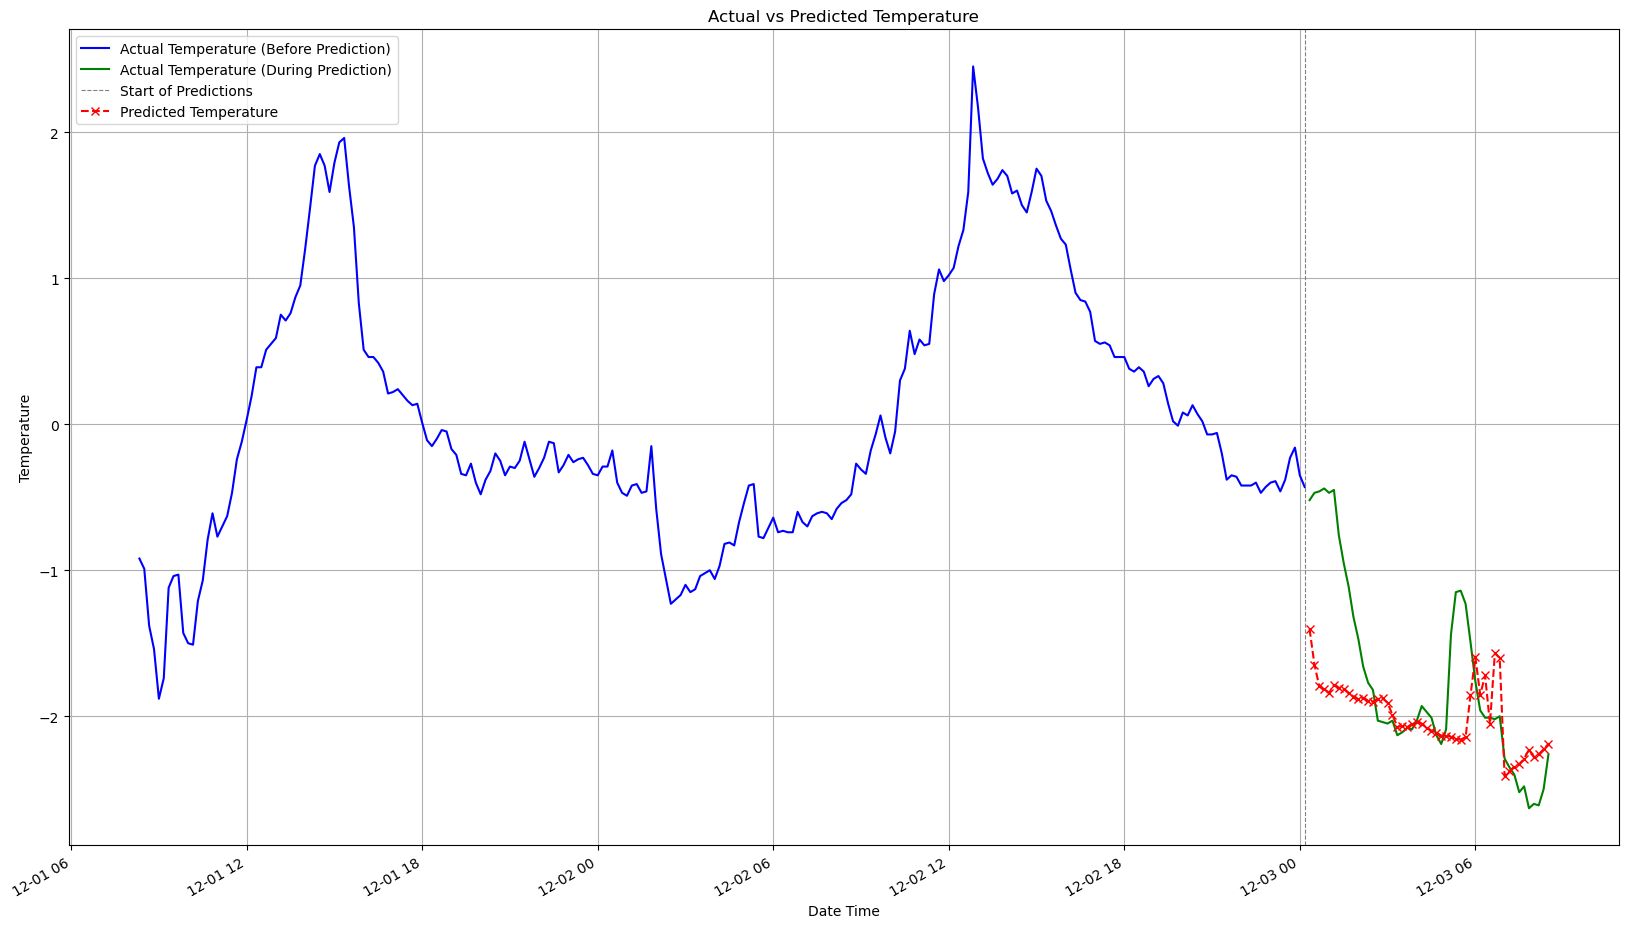

                  Date  Predicted Temperature  Actual Temperature
0  2017-12-03 00:20:00              -1.402640               -0.52
1  2017-12-03 00:30:00              -1.647045               -0.47
2  2017-12-03 00:40:00              -1.795614               -0.46
3  2017-12-03 00:50:00              -1.816730               -0.44
4  2017-12-03 01:00:00              -1.838636               -0.47
5  2017-12-03 01:10:00              -1.787335               -0.45
6  2017-12-03 01:20:00              -1.803477               -0.76
7  2017-12-03 01:30:00              -1.814401               -0.95
8  2017-12-03 01:40:00              -1.841160               -1.11
9  2017-12-03 01:50:00              -1.864777               -1.32
10 2017-12-03 02:00:00              -1.884722               -1.47
11 2017-12-03 02:10:00              -1.873071               -1.66
12 2017-12-03 02:20:00              -1.893677               -1.77
13 2017-12-03 02:30:00              -1.899885               -1.82
14 2017-12

In [38]:
start_idx = 360
sequence_length = 240  # Número de pasos hacia el pasado (por ejemplo, 240 horas)
num_predictions = 50  # Número de predicciones futuras

if start_idx < sequence_length:
    raise ValueError(f'start_idx ({start_idx}) debe ser mayor o igual a sequence_length ({sequence_length})')

# Función para denormalizar los datos
def denormalize(data, mean, std):
    return data * std + mean

# Preparar datos de validación
x_val_last = val_data.iloc[start_idx - sequence_length:start_idx][selected_features].values.reshape((1, sequence_length, len(selected_features)))

# Crear listas para almacenar las predicciones y sus fechas
predicted_temperatures = []
predicted_dates = []
actual_temperatures = []

# Realizar predicciones secuenciales de la muestra 200 a la 210
for i in range(num_predictions):
    # Índice actual
    current_idx = start_idx + i
    
    # Realizar la predicción
    actual_temp = val_data['T (degC)'].iloc[current_idx]
    actual_temperatures.append(actual_temp)
    
    predicted_temp = model.predict(x_val_last)
    predicted_temp=predicted_temp.flatten()[0]
    """ predicted_temp = denormalize(predicted_temp.flatten()[0], data_mean[1], data_std[1]) """
    print(predicted_temp)
    # Añadir la predicción y la fecha correspondiente a las listas
    predicted_temperatures.append(predicted_temp)
    predicted_dates.append(val_data.index[current_idx])

    # Preparar las nuevas características de entrada para la próxima predicción
    new_feature_row = x_val_last[:, 1:, :]  # Descartar la fila más antigua
    
    new_feature = np.zeros((1, 1, len(selected_features)))
    new_feature[0, 0, 1:] = x_val_last[0, -1, 1:]  # Mantener las características excepto la primera
    new_feature[0, 0, 0] = predicted_temp  # Añadir la nueva predicción a la primera característica
    
    x_val_last = np.concatenate((new_feature_row, new_feature), axis=1)

# Obtener las fechas correspondientes a los datos de validación
dates_val = val_data.index[start_idx - sequence_length:start_idx + num_predictions]
y_val_truncated = val_data['T (degC)'].iloc[start_idx - sequence_length:start_idx + num_predictions]

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(20, 12))

# Trazar temperatura real antes del inicio de predicciones
ax.plot(dates_val[:sequence_length], y_val_truncated[:sequence_length], label='Actual Temperature (Before Prediction)', color='blue')

# Trazar temperatura real después del inicio de predicciones en verde
ax.plot(dates_val[sequence_length:], y_val_truncated[sequence_length:], label='Actual Temperature (During Prediction)', color='green')

# Trazar línea vertical para indicar inicio de predicciones
ax.axvline(x=dates_val[sequence_length - 1], linestyle='--', color='gray', linewidth=0.8, label='Start of Predictions')

# Trazar predicciones de temperatura con 'X' rojas
ax.plot(predicted_dates, predicted_temperatures, linestyle='--', color='red', marker='x', label='Predicted Temperature')

# Añadir anotaciones para las predicciones
""" for i, txt in enumerate(predicted_temperatures):
    ax.annotate(f'{txt:.2f}', (predicted_dates[i], predicted_temperatures[i]), textcoords="offset points", xytext=(0,10), ha='center') """

# Configurar etiquetas y título
ax.set_xlabel('Date Time')
ax.set_ylabel('Temperature')
ax.legend()
ax.set_title('Actual vs Predicted Temperature')
ax.grid(True)

# Rotar las fechas para mejor visualización
fig.autofmt_xdate()

# Mostrar gráfico
plt.show()

prediction_results = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted Temperature': predicted_temperatures,
    'Actual Temperature': actual_temperatures
})
print(prediction_results)

El problema con este modelo viene a partir de aproximadamente las 75 predicciones, momento en el que se queda aparentemente estancado en una temperatura en concreto y no avanza mas allá. No he llegado a solucionar este problema pero si he podido localizarlo. Podría deberse al problema arrastrado que se ha mencionado anteriormente o puede deberse a muchos otros factores. Queda para ser estudiado mas adelante.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.40264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
-1.6470455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
-1.7956145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-1.8167298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.838636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.7873349
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.8034766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8144008
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-1.8411598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8647766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8847215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8730712
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8936771
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8998849
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8803074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.8777995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
-1.9086623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-1.99073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-2.0717938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-2.068499
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

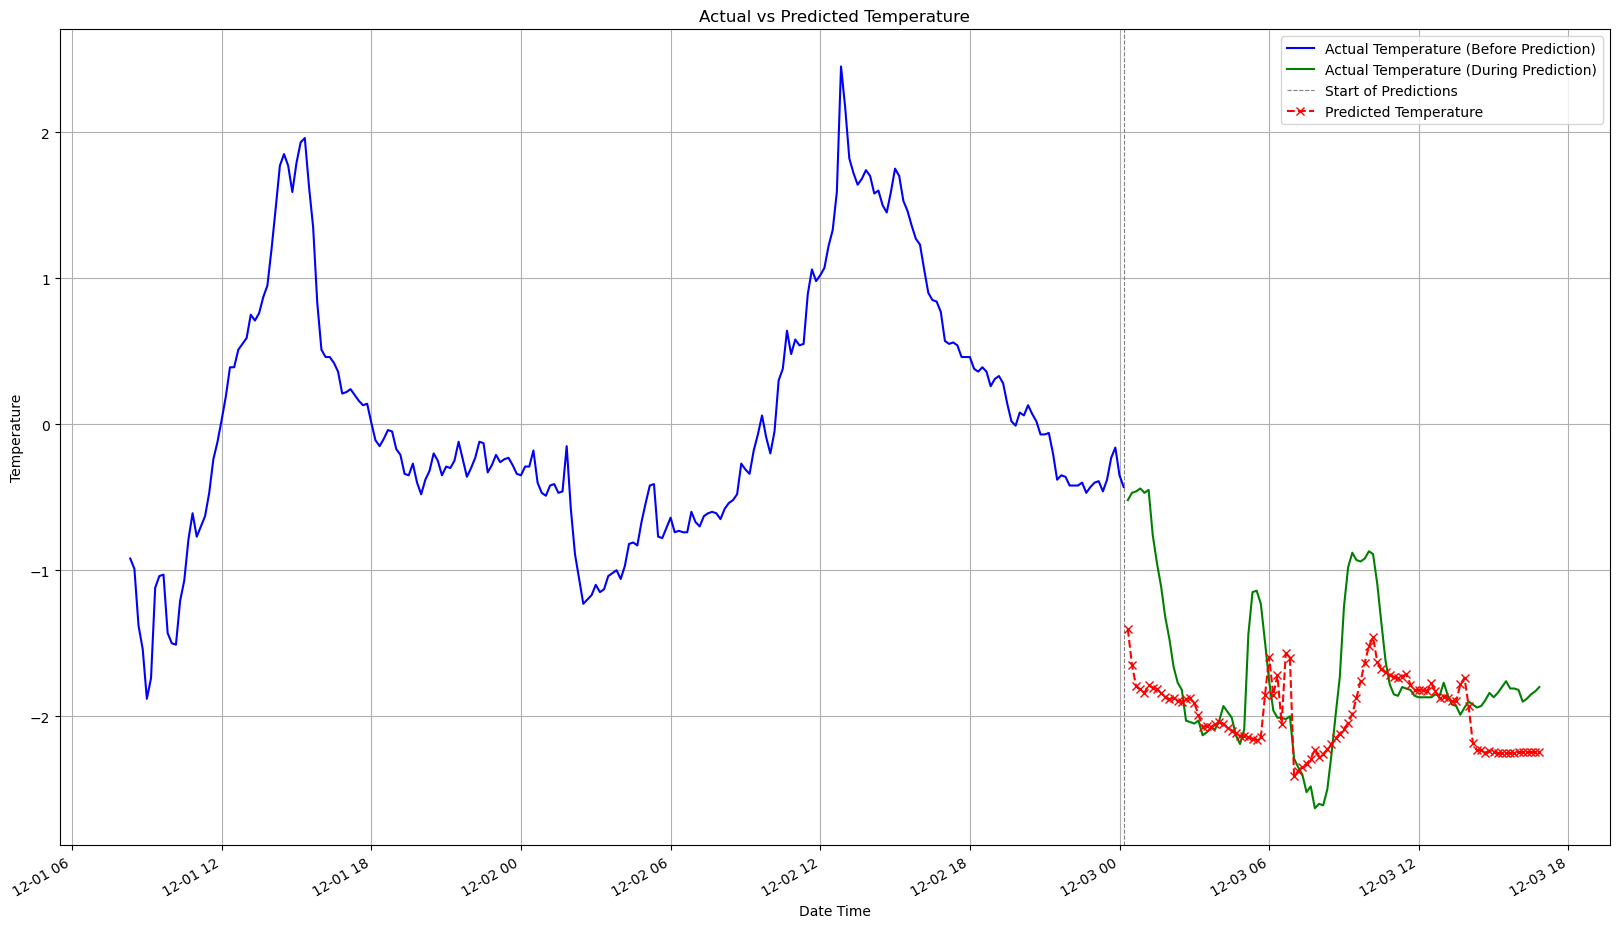

                  Date  Predicted Temperature  Actual Temperature
0  2017-12-03 00:20:00              -1.402640               -0.52
1  2017-12-03 00:30:00              -1.647045               -0.47
2  2017-12-03 00:40:00              -1.795614               -0.46
3  2017-12-03 00:50:00              -1.816730               -0.44
4  2017-12-03 01:00:00              -1.838636               -0.47
..                 ...                    ...                 ...
95 2017-12-03 16:10:00              -2.244945               -1.90
96 2017-12-03 16:20:00              -2.245105               -1.88
97 2017-12-03 16:30:00              -2.245455               -1.85
98 2017-12-03 16:40:00              -2.243415               -1.83
99 2017-12-03 16:50:00              -2.242632               -1.80

[100 rows x 3 columns]


In [37]:
start_idx = 360
sequence_length = 240  # Número de pasos hacia el pasado (por ejemplo, 240 horas)
num_predictions = 100  # Número de predicciones futuras

if start_idx < sequence_length:
    raise ValueError(f'start_idx ({start_idx}) debe ser mayor o igual a sequence_length ({sequence_length})')

# Función para denormalizar los datos
def denormalize(data, mean, std):
    return data * std + mean

# Preparar datos de validación
x_val_last = val_data.iloc[start_idx - sequence_length:start_idx][selected_features].values.reshape((1, sequence_length, len(selected_features)))

# Crear listas para almacenar las predicciones y sus fechas
predicted_temperatures = []
predicted_dates = []
actual_temperatures = []

# Realizar predicciones secuenciales de la muestra 200 a la 210
for i in range(num_predictions):
    # Índice actual
    current_idx = start_idx + i
    
    # Realizar la predicción
    actual_temp = val_data['T (degC)'].iloc[current_idx]
    actual_temperatures.append(actual_temp)
    
    predicted_temp = model.predict(x_val_last)
    predicted_temp=predicted_temp.flatten()[0]
    """ predicted_temp = denormalize(predicted_temp.flatten()[0], data_mean[1], data_std[1]) """
    print(predicted_temp)
    # Añadir la predicción y la fecha correspondiente a las listas
    predicted_temperatures.append(predicted_temp)
    predicted_dates.append(val_data.index[current_idx])

    # Preparar las nuevas características de entrada para la próxima predicción
    new_feature_row = x_val_last[:, 1:, :]  # Descartar la fila más antigua
    
    new_feature = np.zeros((1, 1, len(selected_features)))
    new_feature[0, 0, 1:] = x_val_last[0, -1, 1:]  # Mantener las características excepto la primera
    new_feature[0, 0, 0] = predicted_temp  # Añadir la nueva predicción a la primera característica
    
    x_val_last = np.concatenate((new_feature_row, new_feature), axis=1)

# Obtener las fechas correspondientes a los datos de validación
dates_val = val_data.index[start_idx - sequence_length:start_idx + num_predictions]
y_val_truncated = val_data['T (degC)'].iloc[start_idx - sequence_length:start_idx + num_predictions]

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(20, 12))

# Trazar temperatura real antes del inicio de predicciones
ax.plot(dates_val[:sequence_length], y_val_truncated[:sequence_length], label='Actual Temperature (Before Prediction)', color='blue')

# Trazar temperatura real después del inicio de predicciones en verde
ax.plot(dates_val[sequence_length:], y_val_truncated[sequence_length:], label='Actual Temperature (During Prediction)', color='green')

# Trazar línea vertical para indicar inicio de predicciones
ax.axvline(x=dates_val[sequence_length - 1], linestyle='--', color='gray', linewidth=0.8, label='Start of Predictions')

# Trazar predicciones de temperatura con 'X' rojas
ax.plot(predicted_dates, predicted_temperatures, linestyle='--', color='red', marker='x', label='Predicted Temperature')

# Añadir anotaciones para las predicciones
""" for i, txt in enumerate(predicted_temperatures):
    ax.annotate(f'{txt:.2f}', (predicted_dates[i], predicted_temperatures[i]), textcoords="offset points", xytext=(0,10), ha='center') """

# Configurar etiquetas y título
ax.set_xlabel('Date Time')
ax.set_ylabel('Temperature')
ax.legend()
ax.set_title('Actual vs Predicted Temperature')
ax.grid(True)

# Rotar las fechas para mejor visualización
fig.autofmt_xdate()

# Mostrar gráfico
plt.show()

prediction_results = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted Temperature': predicted_temperatures,
    'Actual Temperature': actual_temperatures
})
print(prediction_results)